In [1]:
''' Bibliotecas '''
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import control as ct
from geneticalgorithm import geneticalgorithm as ga 
from do_mpc.model import Model
from do_mpc.controller import MPC
from do_mpc.simulator import Simulator
from do_mpc.graphics import Graphics
from scipy.integrate import solve_ivp

/home/miguel/Estudo/Sistemas Inteligentes de Controle/.venv/lib/python3.12/site-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/home/miguel/Estudo/Sistemas Inteligentes de Controle/.venv/lib/python3.12/site-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


# Simulação do sistema não linear no domínio do tempo sem controle

In [2]:
''' Equações do sistema não linear do biorreator '''

''' 

Unidades de medida do sistema:
Biomassa (X) em g/L
Substrato de entrada (Sf) em g/L
Substrato no biorreator (S) em g/L
Taxa de diluição (D) em 1/h [D = F/V = (L/h)/L = h⁻¹]

'''

# Constantes das equações
Sf = 1 # (L/h)
mi_max = 0.5 # (L/h)
Ks = 0.1 # (g/L)
Y = 0.4 # (g/g)
D_max = (mi_max*Sf)/(Ks + Sf) # (1/h)

def mi_function(S): # (L/h)
    return (mi_max * S)/(Ks + S)

def X_derivative(S, X, D):
    return mi_function(S)*X - D*X

def S_derivative(Sf, S, X, D):
    return D*(Sf - S) - mi_function(S)*(1/Y)*X

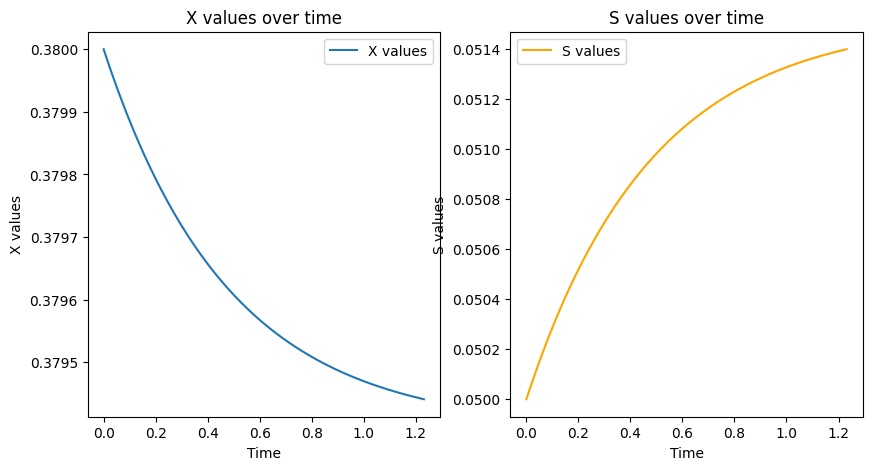

In [3]:
''' Simulação do sistema a partir de valores iniciais padrão '''

''' Initial conditions 1 '''
X0 = 0.38
S0 = 0.05
D = 0.17

time = np.linspace(0, 10, 1000)
dt = time[1] - time[0]

X_values = [X0]
S_values = [S0] 
dx = 1
ds = 1
it = 1
while (abs(dx) > 0.0001 and abs(ds) > 0.0001):
    dx = X_derivative(S_values[-1], X_values[-1], D)
    ds = S_derivative(Sf=1.0, S=S_values[-1], X=X_values[-1], D=D)

    X_new = X_values[-1] + dx * dt
    S_new = S_values[-1] + ds * dt
    
    X_values.append(X_new)
    S_values.append(S_new)
    it+=1

time_plot = np.linspace(0, it*dt, it)

''' Plotting the results 1'''
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(time_plot, X_values, label='X values')
plt.title('X values over time')
plt.xlabel('Time')
plt.ylabel('X values')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(time_plot, S_values, label='S values', color='orange')
plt.title('S values over time')
plt.xlabel('Time')
plt.ylabel('S values')
plt.legend()

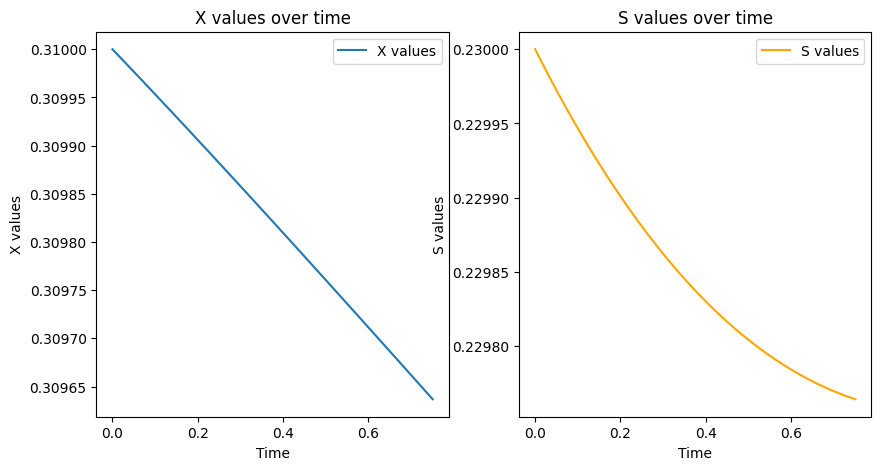

In [4]:
''' Initial conditions 2 '''
X0 = 0.31
S0 = 0.23
D = 0.35

dt = time[1] - time[0]

X_values = [X0]
S_values = [S0] 
dx = 1
ds = 1
it = 1
while (abs(dx) > 0.0001 and abs(ds) > 0.0001):
    dx = X_derivative(S_values[-1], X_values[-1], D)
    ds = S_derivative(1.0, S_values[-1], X_values[-1], D)

    X_new = X_values[-1] + dx * dt
    S_new = S_values[-1] + ds * dt
    
    X_values.append(X_new)
    S_values.append(S_new)
    it+=1

time = np.linspace(0, it*dt, it)

''' Plotting the results 2'''
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(time, X_values, label='X values')
plt.title('X values over time')
plt.xlabel('Time')
plt.ylabel('X values')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(time, S_values, label='S values', color='orange')
plt.title('S values over time')
plt.xlabel('Time')
plt.ylabel('S values')
plt.legend()

Função de simulação do sistema não linear

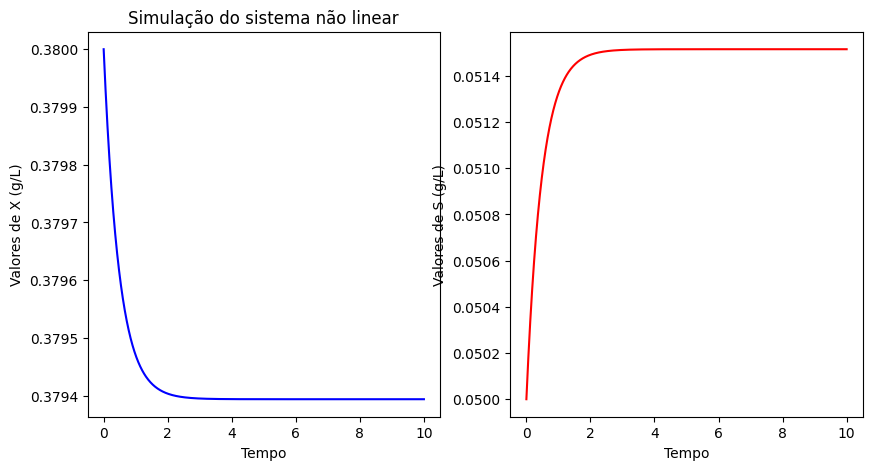

In [5]:
''' Nonlinear bioreactor model with odeint '''
D = 0.17 # (1/h)
Sf = 1.0 # (g/L)

# Combined nonlinear function
def bioreactor_nonlinear(y, t, D_func, Sf_func, X_derivative, S_derivative):
    x, s = y
    D_value = 0.17 # D_func(t)
    Sf_value = 1.0 # Sf_func(t)
    
    dxdt = X_derivative(S=s, X=x, D=D_value)
    dsdt = S_derivative(Sf=Sf_value, S=s, X=x, D=D_value)
    return np.array([dxdt, dsdt])

# Input signals - sinusoidal perturbations
def D_input(t):
    return D + 0.05 * D * np.sin(0.5 * t) 

def Sf_input(t):
    return Sf + 0.1 * Sf * np.sin(0.3 * t)

# Initial conditions
x0 = 0.38
s0 = 0.05

# Simulation with odeint
time = np.linspace(0, 10, 1000)
resp = odeint(bioreactor_nonlinear, [x0, s0], time, args=(D_input, Sf_input, X_derivative, S_derivative))
x_odeint, s_odeint = resp.T

plt.figure(figsize=(10,5))
plt.subplot(1, 2 ,1)
plt.plot(time, x_odeint, color='blue')
plt.title('Simulação do sistema não linear')
plt.xlabel('Tempo')
plt.ylabel('Valores de X (g/L)')

plt.subplot(1, 2, 2)
plt.plot(time, s_odeint, color='red')
plt.xlabel('Tempo')
plt.ylabel('Valores de S (g/L)')
plt.show()

In [6]:
def bioreactor_nonlinear(y, t, D_func, Sf_func):
    ''' Função que calcula a dinâmica do sistema a partir de suas equações '''
    x, s = y
    D_value = D_func(t)
    Sf_value = Sf_func(t)
    
    dxdt = X_derivative(S=s, X=x, D=D_value)
    dsdt = S_derivative(Sf=Sf_value, S=s, X=x, D=D_value)

    return np.array([dxdt, dsdt])

def non_linear_simulation(x0, s0, time, D_input, Sf_input, plot_x=True, plot_s=True):
    ''' Função para simular o comportamento do sistema apartir de certas entradas '''
    D_in = D_input
    Sf_in = Sf_input
    x0=x0
    s0=s0

    # Resolução das equações diferenciais simples (primeira/segunda ordem)
    result = odeint(bioreactor_nonlinear, [x0, s0], time, args=(D_in, Sf_in))
    x, s = result.T

    # Plotagem dos gráficos de X e S ao longo do tempo informado
    if plot_x == True:
        plt.figure(figsize=(12,5))
        plt.subplot(1, 2 ,1)
        plt.plot(time, x, color='blue')
        plt.title('Simulação do sistema não linear em X')
        plt.xlabel('Tempo')
        plt.ylabel('Valores de X (g/L)')
        plt.locator_params(axis='x', nbins=12)
        plt.locator_params(axis='y', nbins=12)
    if plot_s == True:
        plt.subplot(1, 2, 2)
        plt.plot(time, s, color='red')
        plt.title('Simulação do sistema não linear em S')
        plt.xlabel('Tempo')
        plt.ylabel('Valores de S (g/L)')
        plt.locator_params(axis='x', nbins=12)
        plt.locator_params(axis='y', nbins=12)
        plt.show()

    return x, s    

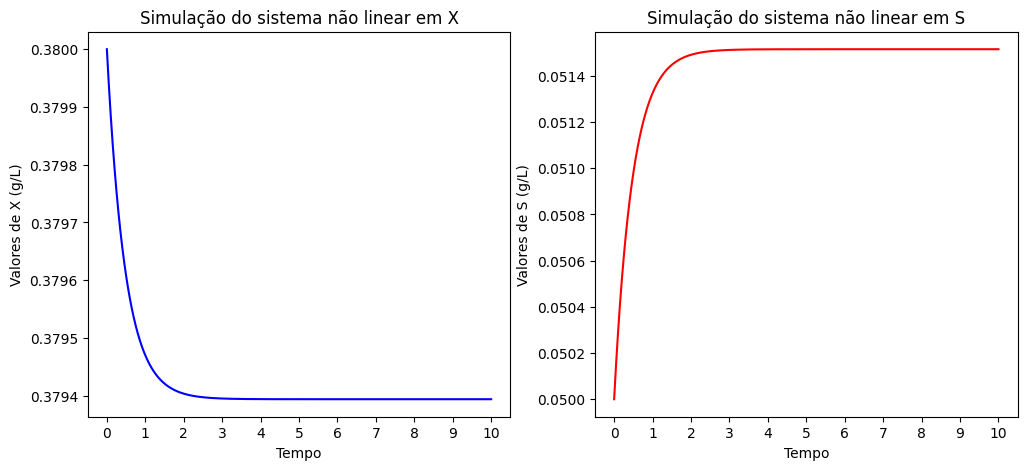

In [7]:
def D_input(t):
    return 0.17 

def Sf_input(t):
    return 1.0

_,_ = non_linear_simulation(
        x0=0.38, s0=0.05, time=np.linspace(0, 10, 1000),
        D_input=D_input, Sf_input=Sf_input
    )

Determinar a relação entre as entradas e saídas do sistema através da RGA

In [8]:
# Resolução das equações dos estados estacionários
S_ss = (Ks * D) / (mi_max - D) # Equação para S
X_ss = Y * (Sf - S_ss) # Equação para X

In [9]:
''' Linearização do sistema para facilitar análises no domínio da frequência '''

# TENHO QUE CHECAR SE ESSA LINEARIZAÇÃO ESTÁ CERTA!!! POR ENQUANTO, VOU USÁ-LA

# Derivatives obtained manually
a = (mi_max * Ks) / (Ks + S_ss)**2
A00 = 0
A01 = X_ss
A10 = (-mi_max * S_ss) / (Y * (Ks + S_ss))
A11 = -D - (X_ss * (a/Y))

# A matrix of the linearized system
A = np.array([[A00, A01],
             [A10, A11]])

# B matrix of the linearized system
B = np.array([[-X_ss, 0],
              [Sf - S_ss, D]])

# C matrix of the linearized system
C = np.eye(2)

# D matrix of the linearized system
D_matrix = np.zeros((2, 2))

# Defining the state space system
sys_ss = ct.ss(A, B, C, D_matrix)

In [10]:
# Converting the linearized system to transfer function
sys_tf = ct.tf(sys_ss)

# Individual transfer functions of X and S
G_x = ct.tf(sys_tf.num[0][0], sys_tf.den[0][0])
G_s = ct.tf(sys_tf.num[1][0], sys_tf.den[1][0])

In [11]:
def determine_gain_matrix(sys_tf):
    # Returns the gain matrix K from the transfer function
    K = ct.dcgain(sys_tf)
    
    return K

K = determine_gain_matrix(sys_tf)

In [12]:
def calculate_rga(K_matrix):
    K = np.asarray(K_matrix, dtype=float) 
    if K.shape[0] != K.shape[1]:
        raise ValueError("A matriz de ganhos K deve ser quadrada.")

    try:
        K_inv = np.linalg.inv(K)
    except np.linalg.LinAlgError:
        print("Erro: A matriz de ganhos K é singular e não pode ser invertida.")
        return None
        
    K_inv_T = K_inv.T
    
    # Multiplicação elemento a elemento (Produto de Hadamard)
    RGA_matrix = K * K_inv_T 
    
    return RGA_matrix

RGA_matrix = calculate_rga(K)
print(RGA_matrix)

[[-4.44089210e-16  1.00000000e+00]
 [ 1.00000000e+00 -6.64778637e-16]]


Controle PID de maneira desacoplada

# Método da Curva de Reação 

Determinação da $K_p$, $\tau$ e $\theta$ através da curva de reação

In [13]:
# Function to obtain the parameters Kp, tau, and theta from the step response of a transfer function
def get_parameters_znrc(x0, s0, U0, Uf, deg_tempo, tempo_final, num_points=1000, D_in=None, Sf_in=None, step_x=True):
    # Step response simulation
    time = np.linspace(0, tempo_final, num_points)
    if step_x == True:
        x_resp, s_resp = non_linear_simulation(
                        x0=x0, s0=s0, time=time,
                        D_input=D_in,
                        Sf_input=Sf_in,
                        plot_s=False
                    )
    else:
        x_resp, s_resp = non_linear_simulation(
                        x0=x0, s0=s0, time=time,
                        D_input=D_in,
                        Sf_input=Sf_in,
                        plot_x=False
                    )

    # Valor de Kp
    if step_x:
        x_initial = x_resp[np.where(time >= deg_tempo)[0][0]]
        delta_x = x_resp[-1] - x_initial # Supoẽ que o sistema chegou no regime estacionário

        # Determinação de Kp para análise de X
        K_x = (delta_x)/(Uf - U0)
        
        # Cálculo do theta
        theta_x = 0.0
        threshold = 0.02 # 2%
        x_condition = x_initial + threshold*delta_x
        indices = np.where(x_resp >= x_condition)[0]
        theta_x = time[indices[0]] - deg_tempo

        # Cálculo de tau
        tau_x = 0.0
        x_initial = x_resp[indices[0]]
        indices_tau = np.where(x_resp >= (x_initial + 0.632*delta_x))[0]
        tau_x = time[indices_tau[0]] - theta_x

        return K_x, tau_x, theta_x
    else:
        s_initial = s_resp[np.where(time >= deg_tempo)[0][0]]
        delta_s = s_resp[-1] - s_initial

        # Determinação de Kp para análise de X
        K_s = (delta_s)/(Uf - U0)
        
        # Cálculo do theta
        theta_s = 0.0
        threshold = 0.02 # 5%
        s_condition = s_initial + threshold*delta_s
        indices = np.where(s_resp >= s_condition)[0]
        theta_s = time[indices[0]] - deg_tempo

        # Cálculo de tau
        tau_s = 0.0
        s_initial = s_resp[indices[0]]
        indices_tau = np.where(s_resp >= (s_initial + 0.632*delta_s))[0]
        tau_s = time[indices_tau[0]] - theta_s

        return K_s, tau_s, theta_s

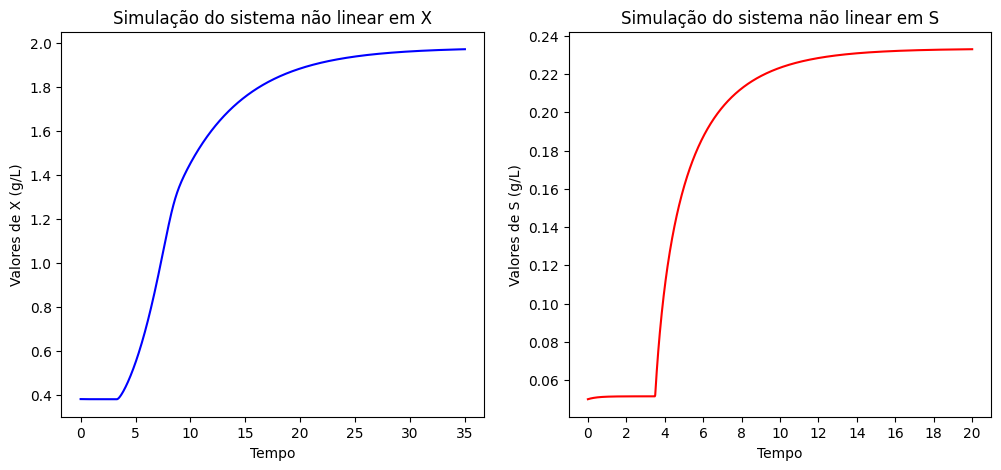

Valores para X
k=0.39814363521520935, theta=0.8538538538538538 e tau=8.815815815815816
Valores para S
k=1.0084284618480366, theta=0.5235235235235236 e tau=4.781781781781781


In [14]:
''' Determinação dos valores dos Kps, Thetas e Taus pelo método da curva de reação '''
def D_in(t):
    return 0.17

def Sf_in(t):
    return 1.0 if t < 3.3 else 5.0 # Delay de 0.3h

k_x_znrc, tau_x_znrc, theta_x_znrc = get_parameters_znrc(
                                                    x0=0.38, s0=0.05, U0=1.0, 
                                                    Uf=5.0, deg_tempo=3.0, tempo_final=35,
                                                    D_in=D_in, Sf_in=Sf_in
                                                    )

def D_in(t):
    return 0.17 if t < 3.5 else 0.35 # Delay de 0.5h

def Sf_in(t):
    return 1.0

k_s_znrc, tau_s_znrc, theta_s_znrc = get_parameters_znrc(
                                                    x0=0.38, s0=0.05, U0=0.17, 
                                                    Uf=0.35, deg_tempo=3.0, tempo_final=20,
                                                    D_in=D_in, Sf_in=Sf_in, step_x=False
                                                    )

print(f'Valores para X\nk={k_x_znrc}, theta={theta_x_znrc} e tau={tau_x_znrc}')
print(f'Valores para S\nk={k_s_znrc}, theta={theta_s_znrc} e tau={tau_s_znrc}')

In [15]:
# Function to tune the PID controller using the Ziegler-Nichols Reaction Curve (ZNRC) method
def znrc_tuning(Kp, tau, theta, controller_type='PI'):
    if controller_type == 'P':
        Kp = tau / (theta)
        Ti = float('inf') # Too large to not influence the system
        Td = 1e-16
    elif controller_type == 'PI':
        Kp = 0.9 * tau / (theta)
        Ti = tau / 0.3
        Td = 0.0
    elif controller_type == 'PID':
        Kp = 1.2 * tau / (theta)
        Ti = 2.0 * theta
        Td = 0.5 * theta

    return np.array([Kp, Ti, Td])

def determine_pid_params(Kp, Ti, Td):
    # Defining the gains of the system
    Ki = Kp / Ti
    Kd = Kp * Td

    return np.array([Kp, Ki, Kd])

# Para X
params_x_znrc_tuning = znrc_tuning(k_x_znrc, tau_x_znrc, theta_x_znrc)
params_x_znrc = determine_pid_params(params_x_znrc_tuning[0], params_x_znrc_tuning[1], params_x_znrc_tuning[2])

# Para S
params_s_znrc_tuning = znrc_tuning(k_s_znrc, tau_s_znrc, theta_s_znrc)
params_s_znrc = determine_pid_params(params_s_znrc_tuning[0], params_s_znrc_tuning[1], params_s_znrc_tuning[2])

print(f'Valores de Kp, Ki e Kd para o controlador de X ZNRC\nKp={params_x_znrc[0]}, Ki={params_x_znrc[1]} e Kd={params_x_znrc[2]}')
print(f'Valores de Kp, Ki e Kd para o controlador de S ZNRC\nKp={params_s_znrc[0]}, Ki={params_s_znrc[1]} e Kd={params_s_znrc[2]}')


Valores de Kp, Ki e Kd para o controlador de X ZNRC
Kp=9.292262602579132, Ki=0.3162133645955451 e Kd=0.0
Valores de Kp, Ki e Kd para o controlador de S ZNRC
Kp=8.220458891013383, Ki=0.515736137667304 e Kd=0.0


Definição das classes de PID e do sistema não linear

In [16]:
class PID:
    def __init__(self, Kp, Ki, Kd, output_limits=(None, None), sample_time=0.01):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd

        self._min_output, self._max_output = output_limits

        self._sample_time = sample_time
        self._last_time = None

        self._proportional = 0
        self._integral = 0
        self._derivative = 0

        self._previous_error = 0 # Erro do ciclo anterior para o termo derivativo
        self._last_output = 0    # Última saída calculada

        self.reset()

    def update(self, current_error, current_time=None):
        if self._last_time is None:
            self._last_time = current_time
            return 0.0  # Retorna 0 na primeira chamada para evitar cálculos com dt inválido

        dt = current_time - self._last_time

        if dt >= self._sample_time:
            # Termo Proporcional
            self._proportional = current_error

            # Termo Integral
            self._integral += current_error * dt
            # Anti-windup (limitando o termo integral para evitar saturação excessiva)
            if self._min_output is not None and self._max_output is not None:
                if self._integral * self.Ki > self._max_output:
                    self._integral = self._max_output / self.Ki
                elif self._integral * self.Ki < self._min_output:
                    self._integral = self._min_output / self.Ki
            
            # Termo Derivativo
            # Evitar picos no derivativo se o erro mudar muito rapidamente por causa de ruído
            self._derivative = (current_error - self._previous_error) / dt if dt > 0 else 0

            # Calcula a saída total
            output = (self.Kp * self._proportional +
                      self.Ki * self._integral +
                      self.Kd * self._derivative)

            # Aplica limites na saída
            if self._min_output is not None:
                output = max(output, self._min_output)
            if self._max_output is not None:
                output = min(output, self._max_output)

            self._last_output = output
            self._previous_error = current_error
            self._last_time = current_time
        
        return self._last_output

    def set_tunings(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd

    def set_output_limits(self, min_output, max_output):
        self._min_output = min_output
        self._max_output = max_output
        # Resetar integral para evitar wind-up se os limites mudarem
        self.reset()

    def reset(self):
        self._proportional = 0
        self._integral = 0
        self._derivative = 0
        self._previous_error = 0
        self._last_time = None # Força o cálculo de um novo dt na próxima atualização
        self._last_output = 0

class BioReactorSystem:
    def __init__(self, initial_D, initial_Sf, x0, s0):
        self.D = initial_D
        self.Sf = initial_Sf
        self._measured_x = x0
        self._measured_s = s0
        self.mi_max = 0.5 # (L/h)
        self.ks = 0.1 # (g/L)
        self.Y = 0.4 # (g/g)
        self.mi = 0.0
        self._last_time = 0.0
        self._current_time = 0.0

    def _mi_function(self, S):
        return (self.mi_max * S)/(self.ks + S)

    def _derivatives(self, y, t, D, Sf):
        X, S = y

        mi = self._mi_function(S)

        dxdt = mi * X - D * X
        dsdt = D * (Sf - S) - mi * (1 / self.Y) * X

        return np.array([dxdt, dsdt])

    def update_system(self, D_pid, Sf_pid, dt_simulation):
        self.D = D_pid
        self.Sf = Sf_pid

        time = [self._last_time, self._last_time + dt_simulation]
        y0 = [self._measured_x, self._measured_s]
        resp = odeint(
                        self._derivatives,
                        y0=y0,
                        t=time,
                        args=(self.D, self.Sf)
                      )
        
        self._measured_x, self._measured_s = resp[-1]
        self._last_time += dt_simulation

        return np.array([self._measured_x, self._measured_s])
    
    def reset(self):
        self.D = 0.17
        self.Sf = 1.0
        self._measured_x = 0.38
        self._measured_s = 0.05
        self._last_time = 0.0
        self._current_time = 0.0

In [17]:
''' Função para extração de parâmetros de performances dos gráficos '''
def param_performance(setpoint, u0, y, time):
    metrics = {}
    y = np.array(y)
    
    # Cálculo do erro de regime permamente (supondo que o sistema tenha chegado nele)
    y_ss = y[-1]
    metrics['SSE'] = setpoint - y_ss

    # Erro Quadrático Integrado (Integral Squared Error - ISE)
    errors = setpoint - y # Erro em cada ponto do tempo
    metrics['ISE'] = np.sum(errors**2) * dt

    # --- Métricas de Resposta ao Degrau ---
    delta = setpoint - y[0]

    # Tempo de Subida (Rise Time - Tr)
    # Tempo para ir de 10% a 90% da mudança total
    rise_time_10_percent_val = 0.1 * y_ss
    rise_time_90_percent_val = 0.9 * y_ss

    # Encontra os índices onde a resposta cruza os limites de 10% e 90%
    idx_10 = np.where(y >= rise_time_10_percent_val)[0]
    idx_90 = np.where(y >= rise_time_90_percent_val)[0]

    if len(idx_10) > 0 and len(idx_90) > 0:
        t_10 = time[idx_10[0]]
        t_90 = time[idx_90[0]]
        metrics['rise_time'] = t_90 - t_10
    else:
        metrics['rise_time'] = np.nan # Não foi possível calcular

    # Sobressinal (Overshoot - Mp)
    max_y = np.max(y)
    if max_y > setpoint:
        # Porcentagem em relação à mudança total do degrau
        metrics['overshoot'] = ((max_y - setpoint) / setpoint) * 100
    else:
        metrics['overshoot'] = 0.0 # Não houve ultrapassagem

    # Tempo de Acomodação (Settling Time - Ts)
    band_percentage = 0.02
    settling_upper_bound = setpoint * (1 + band_percentage)
    settling_lower_bound = setpoint * (1 - band_percentage)
    
    # Se a resposta vai para cima (degrau positivo)
    if delta >= 0:
        # Encontra o último ponto em que a resposta está fora da banda superior
        outside_band_upper_idx = np.where(y > settling_upper_bound)[0]
        # Encontra o último ponto em que a resposta está fora da banda inferior
        outside_band_lower_idx = np.where(y < settling_lower_bound)[0]
    # Se a resposta vai para baixo (degrau negativo)
    else:
        outside_band_upper_idx = np.where(y > settling_lower_bound)[0] # Invertido para decrescente
        outside_band_lower_idx = np.where(y < settling_upper_bound)[0] # Invertido para decrescente

    last_outside_idx_upper = outside_band_upper_idx[-1] if len(outside_band_upper_idx) > 0 else 0
    last_outside_idx_lower = outside_band_lower_idx[-1] if len(outside_band_lower_idx) > 0 else 0

    settling_time_index = max(last_outside_idx_upper, last_outside_idx_lower)

    # Verifica se o sistema realmente se acomodou até o final da simulação
    # A métrica só é válida se após o settling_time_index, a resposta se manteve na banda.
    metrics['settling_time'] = time[settling_time_index]

    return metrics

In [18]:
# Valor inicial do sistema
initial_x = 0.38
initial_s = 0.05

# Parâmetros de tempo do sistema
simulation_time = 25 # hours
time = np.linspace(0, simulation_time, 1250)
dt_simulation = time[1]

# Instanciando o controlador PID
pid_x_znrc = PID(params_x_znrc[0], params_x_znrc[1]+1, 0.0, output_limits=(0, 5.0), sample_time=dt_simulation)
pid_s_znrc = PID(params_s_znrc[0], params_s_znrc[1], 0.0, output_limits=(0.01, 0.45), sample_time=dt_simulation)
bioreactor_znrc = BioReactorSystem(0.17, 1.0, initial_x, initial_s) # Caso do sistema 1

Simulação concluída para X. Valor final do sistema: 0.99
Simulação concluída para S. Valor final do sistema: 0.79


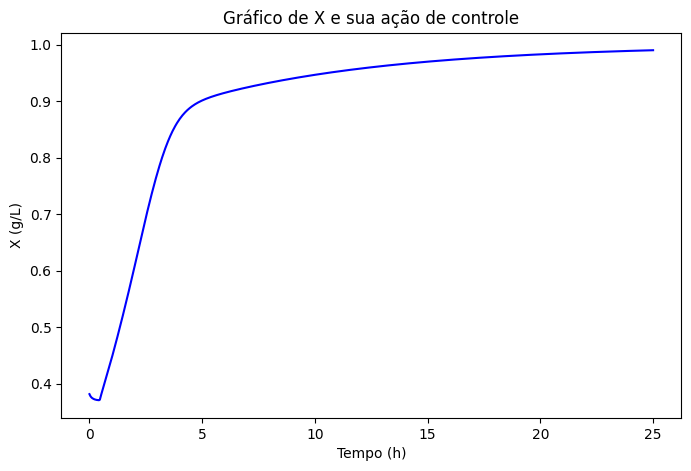

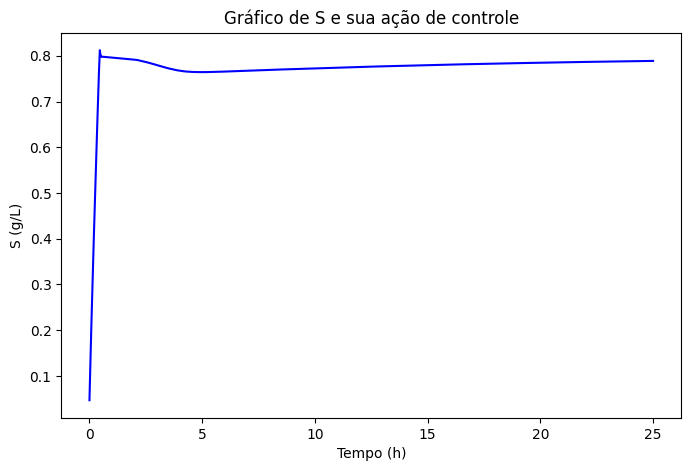

In [19]:
# Resets
bioreactor_znrc.reset()
pid_x_znrc.reset()
pid_s_znrc.reset()

# Definição dos setpoints
setpoint_x = 1.0 # (g/L)
setpoint_s = 0.8 # (g/L)

# Parâmetros da simulação
x_values = []
x_output = []
s_values = []
s_output = []
current_values = np.array([0.0, 0.0])
for i in time:
    current_time = i

    # Calcular o erro
    error_x = setpoint_x - current_values[0] # Erro em X => g/L de X desejado - g/L de X medido
    error_s = setpoint_s - current_values[1] # Erro em S => g/L de S desejado - g/L de S medido

    # Atualizar o PID e obter a saída de controle
    pid_x_output = pid_x_znrc.update(error_x, current_time=current_time)
    pid_s_output = pid_s_znrc.update(error_s, current_time=current_time)
    x_output.append(pid_x_output)
    s_output.append(pid_s_output)

    current_values = bioreactor_znrc.update_system(pid_s_output, pid_x_output, time[1])
    x_values.append(current_values[0])
    s_values.append(current_values[1])

print(f"Simulação concluída para X. Valor final do sistema: {current_values[0]:.2f}")
print(f"Simulação concluída para S. Valor final do sistema: {current_values[1]:.2f}")


plt.figure(figsize=(8, 5))
plt.title('Gráfico de X e sua ação de controle')
plt.plot(time, x_values, color='blue')
#plt.plot(time, x_output, color='red', linestyle='--')
plt.xlabel('Tempo (h)')
plt.ylabel('X (g/L)')
plt.show()

plt.figure(figsize=(8, 5))
plt.title('Gráfico de S e sua ação de controle')
plt.plot(time, s_values, color='blue')
#plt.plot(time, s_output, color='red', linestyle='--')
plt.xlabel('Tempo (h)')
plt.ylabel('S (g/L)')
plt.show()

In [20]:
x_metrics_znrc = param_performance(1.0, 0.38, x_values, time)
s_metrics_znrc = param_performance(0.8, 0.05, s_values, time)

print(f'Métricas de S:\nSSE {x_metrics_znrc['SSE']:.5f}\nISE {x_metrics_znrc['ISE']:.2f}\nt_rise {x_metrics_znrc['rise_time']:.2f}\nOvershoot {x_metrics_znrc['overshoot']:.2f}%\nt_s {x_metrics_znrc['settling_time']:.2f}')
print(f'\nMétricas de S:\nSSE {s_metrics_znrc['SSE']:.5f}\nISE {s_metrics_znrc['ISE']:.2f}\nt_rise {s_metrics_znrc['rise_time']:.2f}\nOvershoot {s_metrics_znrc['overshoot']:.2f}%\nt_s {s_metrics_znrc['settling_time']:.2f}')

Métricas de S:
SSE 0.00955
ISE 0.39
t_rise 4.56
Overshoot 0.00%
t_s 18.47

Métricas de S:
SSE 0.01117
ISE 0.05
t_rise 0.38
Overshoot 1.52%
t_s 19.06


Sistema ZNRC com distúrbios

Simulação concluída para X. Valor final do sistema: 0.99
Simulação concluída para S. Valor final do sistema: 0.79


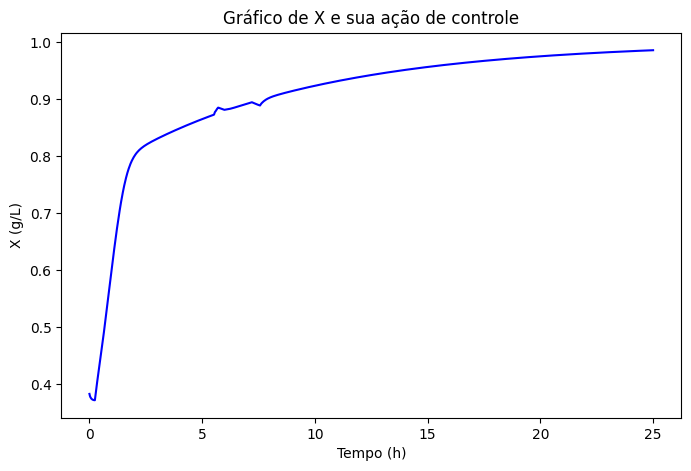

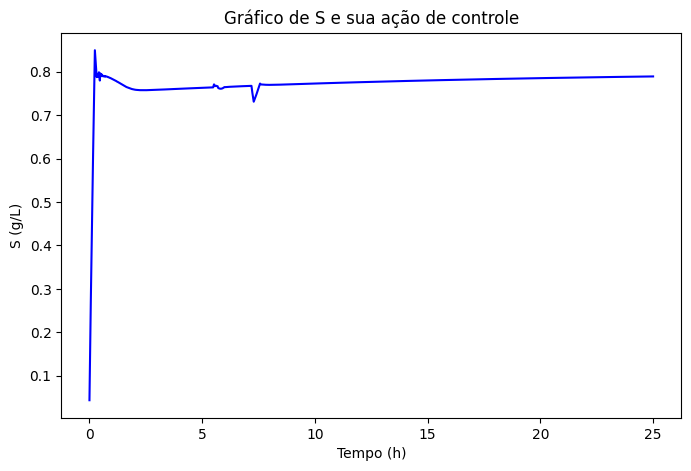

In [21]:
# Resets
bioreactor_znrc.reset()
pid_x_znrc.reset()
pid_s_znrc.reset()

# Definição dos valores de setpoint
setpoint_x = 1.0 # (g/L)
setpoint_s = 0.8 # (g/L)

# Parâmetros da simulação
x_values_dist = []
x_output_dist = []
s_values_dist = []
s_output_dist = []

dist_control = True
dist_start_1 = 5.5 # Hora inicial do distúrbio
dist_end_1 = 5.7 # Hora final do distúrbio

dist_start_2 = 7.2 # Hora inicial do distúrbio
dist_end_2 = 7.3 # Hora final do distúrbio

current_values = np.array([0.0, 0.0])
for i in time:
    current_time = i

    # Calcular o erro
    error_x = setpoint_x - current_values[0] # Erro em X => g/L de X desejado - g/L de X medido
    error_s = setpoint_s - current_values[1] # Erro em S => g/L de S desejado - g/L de S medido

    # Atualizar o PID e obter a saída de controle
    pid_x_output = pid_x_znrc.update(error_x, current_time=current_time)
    pid_s_output = pid_s_znrc.update(error_s, current_time=current_time)
    x_output_dist.append(pid_x_output)
    s_output_dist.append(pid_s_output)

    # Distúrbios
    if dist_control==True and (current_time >= dist_start_1 and current_time <= dist_end_1):
        pid_x_output += 0.2 # Distúrbio na ação de controle de X (Alteração no valor de Sf)
        current_values = bioreactor_znrc.update_system(pid_s_output, pid_x_output, time[1])  
    elif dist_control==True and (current_time >= dist_start_2 and current_time <= dist_end_2):
        pid_x_output -= 0.5 # Distúrbio na ação de controle de X (Alteração no valor de Sf)
        current_values = bioreactor_znrc.update_system(pid_s_output, pid_x_output, time[1])
    else:
        current_values = bioreactor_znrc.update_system(pid_s_output, pid_x_output, time[1])

    if dist_control == False and (current_time >= dist_start_1 and current_time <= dist_end_1):
        current_values[0] += 0.03 # Distúrbio na leitura de X
    if dist_control == False and (current_time >= dist_start_2 and current_time <= dist_end_2):
        current_values[0] -= 0.03 # Distúrbio na leitura de X

    current_values = bioreactor_znrc.update_system(pid_s_output, pid_x_output, time[1])
    x_values_dist.append(current_values[0])
    s_values_dist.append(current_values[1])

print(f"Simulação concluída para X. Valor final do sistema: {current_values[0]:.2f}")
print(f"Simulação concluída para S. Valor final do sistema: {current_values[1]:.2f}")


plt.figure(figsize=(8, 5))
plt.title('Gráfico de X e sua ação de controle')
plt.plot(time, x_values_dist, color='blue')
#plt.plot(time, x_output, color='red', linestyle='--')
plt.xlabel('Tempo (h)')
plt.ylabel('X (g/L)')
plt.show()

plt.figure(figsize=(8, 5))
plt.title('Gráfico de S e sua ação de controle')
plt.plot(time, s_values_dist, color='blue')
#plt.plot(time, s_output, color='red', linestyle='--')
plt.xlabel('Tempo (h)')
plt.ylabel('S (g/L)')
plt.show()

# Método do IMC (Internal Model Control)

In [22]:
# Obtém os valores do modelo através da função de conseguir os parâmetros para a Curve Reaction
k_x_znrc, tau_x_znrc, theta_x_znrc
k_s_znrc, tau_s_znrc, theta_s_znrc

# Define o valor de lambda que dará características de comportamento do sistema
lambda_imc = 0.5

# Function to calculate the PID parameters using the Ziegler-Nichols Reaction Curve method
def imc_tuning(Kp, tau, theta, lambda_imc):
    Kc = tau/(Kp * (lambda_imc + theta))
    Ti = tau
    Td = 0.0 # Inicialmente considerando PI; (tau * theta)/(2*tau + theta)

    return Kc, Ti, Td

# Tuning the PID controller using IMC method
Kc_x_imc, Ti_x_imc, Td_x_imc = imc_tuning(k_x_znrc, tau_x_znrc, theta_x_znrc, lambda_imc)
Kc_s_imc, Ti_s_imc, Td_s_imc = imc_tuning(k_s_znrc, tau_s_znrc, theta_s_znrc, lambda_imc)

# Valores dos coeficiente do PID
Kp_imc = [Kc_x_imc, Kc_s_imc]
Ki_imc = [Kc_x_imc/Ti_x_imc, Kc_s_imc/Ti_s_imc]
Kd_imc = [0.0, 0.0]

In [23]:
# Valor inicial do sistema
initial_x = 0.38
initial_s = 0.05

# Parâmetros de tempo do sistema
simulation_time = 20 # hours
time = np.linspace(0, simulation_time, 1000)
dt_simulation = time[1]

# Creating the PIDs for the IMC method
bioreactor_imc = BioReactorSystem(0.17, 1.0, initial_x, initial_s) # Caso do sistema 1
pid_x_imc = PID(Kp_imc[0], Ki_imc[0], Kd_imc[0], output_limits=(0.01, 5.0), sample_time=dt_simulation)
pid_s_imc = PID(Kp_imc[1], Ki_imc[1], Kd_imc[1], output_limits=(0.01, 0.45), sample_time=dt_simulation)

Simulação concluída para X. Valor final do sistema: 0.99
Simulação concluída para S. Valor final do sistema: 0.80


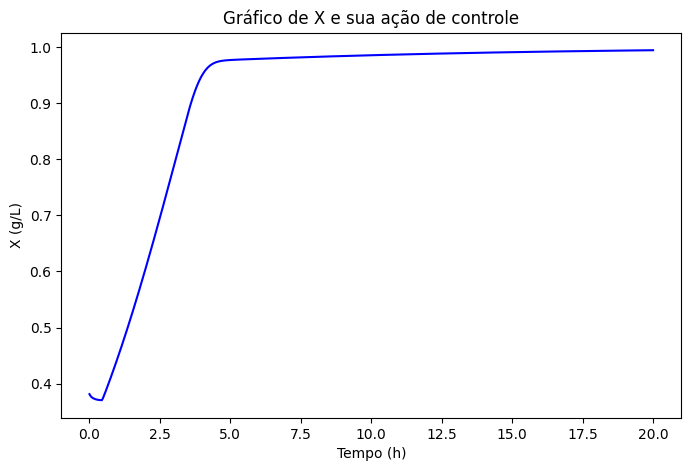

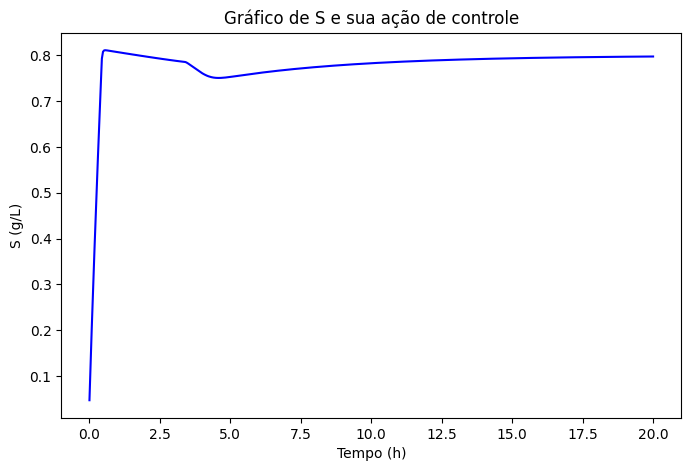

In [24]:
# Resets
bioreactor_imc.reset()
pid_x_imc.reset()
pid_s_imc.reset()

# Simulação dos PIDs com o tuning feito pelo método IMC
setpoint_x = 1.0 # (g/L)
setpoint_s = 0.8 # (g/L)

# Parâmetros da simulação
x_values = []
x_output = []
s_values = []
s_output = []
current_values = np.array([0.0, 0.0])
for i in time:
    current_time = i

    # Calcular o erro
    error_x = setpoint_x - current_values[0] # Erro em X => g/L de X desejado - g/L de X medido
    error_s = setpoint_s - current_values[1] # Erro em S => g/L de S desejado - g/L de S medido

    # Atualizar o PID e obter a saída de controle
    pid_x_output = pid_x_imc.update(error_x, current_time=current_time)
    pid_s_output = pid_s_imc.update(error_s, current_time=current_time)
    x_output.append(pid_x_output)
    s_output.append(pid_s_output)

    current_values = bioreactor_imc.update_system(pid_s_output, pid_x_output, time[1])
    x_values.append(current_values[0])
    s_values.append(current_values[1])

print(f"Simulação concluída para X. Valor final do sistema: {current_values[0]:.2f}")
print(f"Simulação concluída para S. Valor final do sistema: {current_values[1]:.2f}")

plt.figure(figsize=(8, 5))
plt.title('Gráfico de X e sua ação de controle')
plt.plot(time, x_values, color='blue')
#plt.plot(time, x_output, color='red', linestyle='--')
plt.xlabel('Tempo (h)')
plt.ylabel('X (g/L)')
plt.show()

plt.figure(figsize=(8, 5))
plt.title('Gráfico de S e sua ação de controle')
plt.plot(time, s_values, color='blue')
#plt.plot(time, s_output, color='red', linestyle='--')
plt.xlabel('Tempo (h)')
plt.ylabel('S (g/L)')
plt.show()

In [25]:
x_metrics_imc = param_performance(1.0, 0.38, x_values, time)
s_metrics_imc = param_performance(0.8, 0.05, s_values, time)

print(f'Métricas de S:\nSSE {x_metrics_imc['SSE']:.5f}\nISE {x_metrics_imc['ISE']:.2f}\nt_rise {x_metrics_imc['rise_time']:.2f}\nOvershoot {x_metrics_imc['overshoot']:.2f}%\nt_s {x_metrics_imc['settling_time']:.2f}')
print(f'\nMétricas de S:\nSSE {s_metrics_imc['SSE']:.5f}\nISE {s_metrics_imc['ISE']:.2f}\nt_rise {s_metrics_imc['rise_time']:.2f}\nOvershoot {s_metrics_imc['overshoot']:.2f}%\nt_s {s_metrics_imc['settling_time']:.2f}')

Métricas de S:
SSE 0.00548
ISE 0.36
t_rise 3.58
Overshoot 0.00%
t_s 6.45

Métricas de S:
SSE 0.00223
ISE 0.05
t_rise 0.38
Overshoot 1.44%
t_s 10.27


Sistema IMC com distúrbio

Simulação concluída para X. Valor final do sistema: 0.99
Simulação concluída para S. Valor final do sistema: 0.80


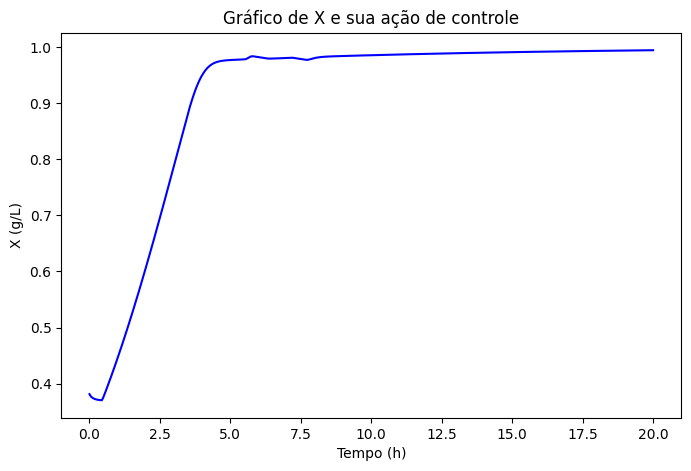

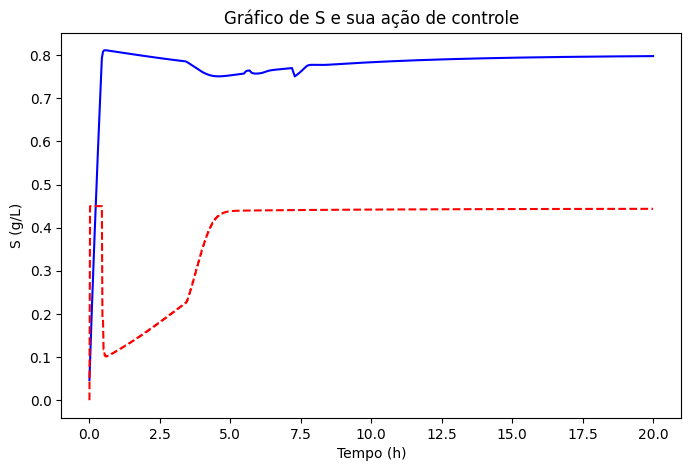

In [26]:
# Resets
bioreactor_imc.reset()
pid_x_imc.reset()
pid_s_imc.reset()

# Simulação dos PIDs com o tuning feito pelo método IMC
setpoint_x = 1.0 # (g/L)
setpoint_s = 0.8 # (g/L)

# Parâmetros da simulação
x_values_dist = []
s_values_dist = []
x_output_dist = []
s_output_dist = []

dist_control = True
dist_start_1 = 5.5 # Hora inicial do distúrbio
dist_end_1 = 5.7 # Hora final do distúrbio

dist_start_2 = 7.2 # Hora inicial do distúrbio
dist_end_2 = 7.3 # Hora final do distúrbio

current_values = np.array([0.0, 0.0])
for i in time:
    current_time = i

    # Calcular o erro
    error_x = setpoint_x - current_values[0] # Erro em X => g/L de X desejado - g/L de X medido
    error_s = setpoint_s - current_values[1] # Erro em S => g/L de S desejado - g/L de S medido

    # Atualizar o PID e obter a saída de controle
    pid_x_output = pid_x_imc.update(error_x, current_time=current_time)
    pid_s_output = pid_s_imc.update(error_s, current_time=current_time)
    x_output_dist.append(pid_x_output)
    s_output_dist.append(pid_s_output)

    # Distúrbios
    if dist_control==True and (current_time >= dist_start_1 and current_time <= dist_end_1):
        pid_x_output += 0.2 # Distúrbio na ação de controle de X (Alteração no valor de Sf)
        current_values = bioreactor_imc.update_system(pid_s_output, pid_x_output, time[1])  
    elif dist_control==True and (current_time >= dist_start_2 and current_time <= dist_end_2):
        pid_x_output -= 0.5 # Distúrbio na ação de controle de X (Alteração no valor de Sf)
        current_values = bioreactor_imc.update_system(pid_s_output, pid_x_output, time[1])
    else:
        current_values = bioreactor_imc.update_system(pid_s_output, pid_x_output, time[1])

    if dist_control == False and (current_time >= dist_start_1 and current_time <= dist_end_1):
        current_values[0] += 0.03 # Distúrbio na leitura de X
    if dist_control == False and (current_time >= dist_start_2 and current_time <= dist_end_2):
        current_values[0] -= 0.03 # Distúrbio na leitura de X

    x_values_dist.append(current_values[0])
    s_values_dist.append(current_values[1])

print(f"Simulação concluída para X. Valor final do sistema: {current_values[0]:.2f}")
print(f"Simulação concluída para S. Valor final do sistema: {current_values[1]:.2f}")

plt.figure(figsize=(8, 5))
plt.title('Gráfico de X e sua ação de controle')
plt.plot(time, x_values_dist, color='blue')
#plt.plot(time, x_output, color='red', linestyle='--')
plt.xlabel('Tempo (h)')
plt.ylabel('X (g/L)')
plt.show()

plt.figure(figsize=(8, 5))
plt.title('Gráfico de S e sua ação de controle')
plt.plot(time, s_values_dist, color='blue')
plt.plot(time, s_output, color='red', linestyle='--')
plt.xlabel('Tempo (h)')
plt.ylabel('S (g/L)')
plt.show()

# Oscilação sustentada

Análise do X

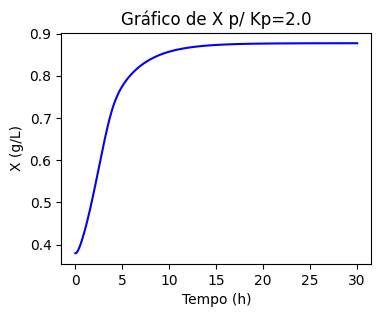

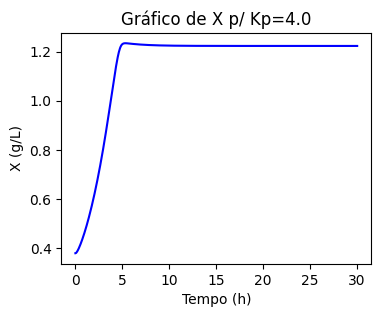

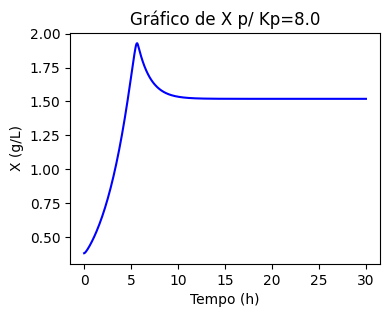

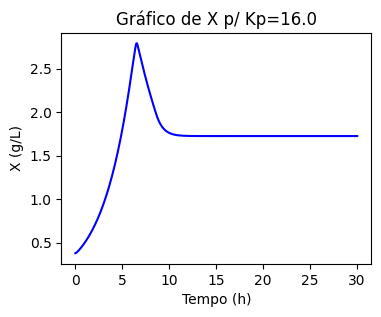

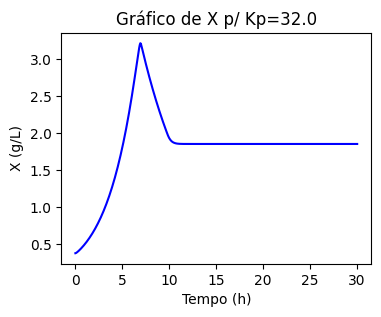

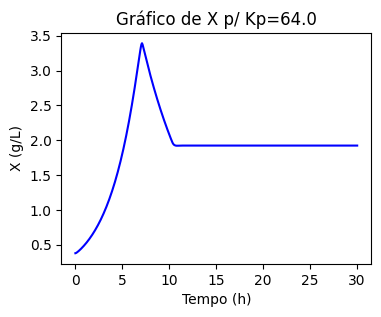

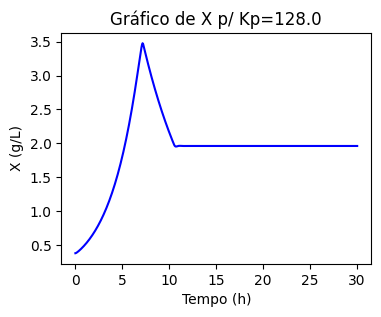

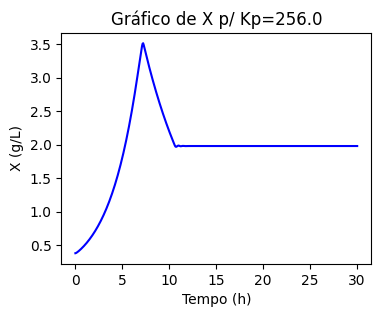

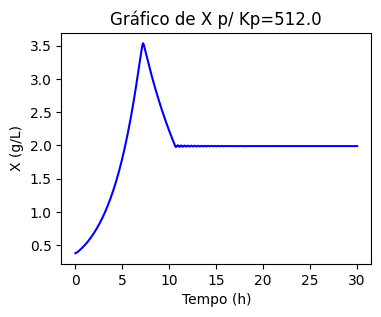

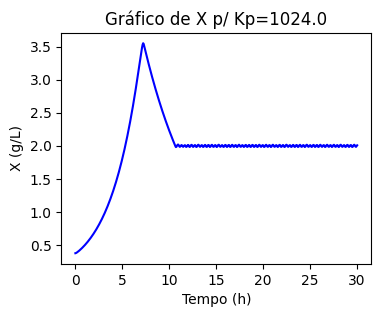

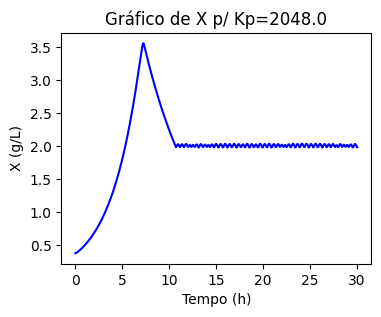

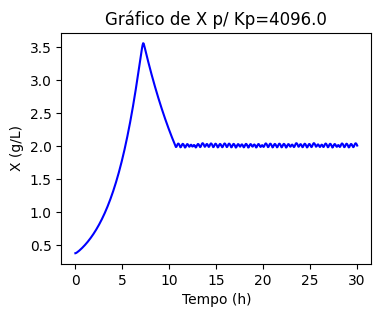

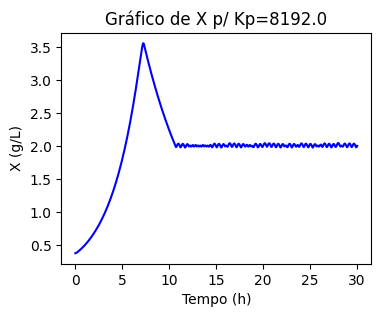

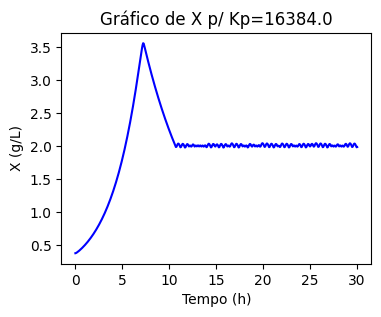

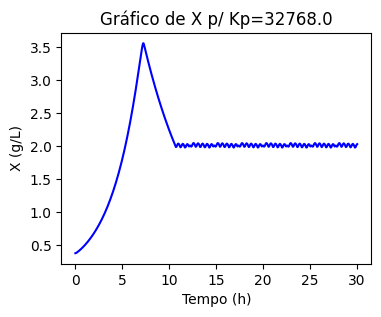

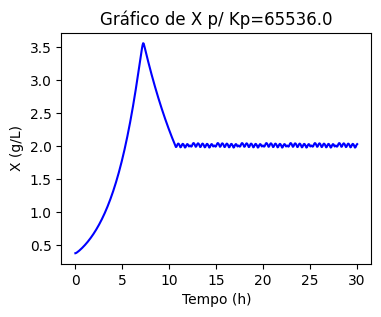

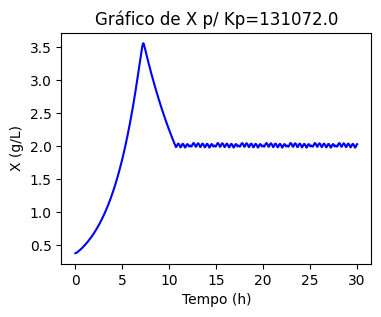

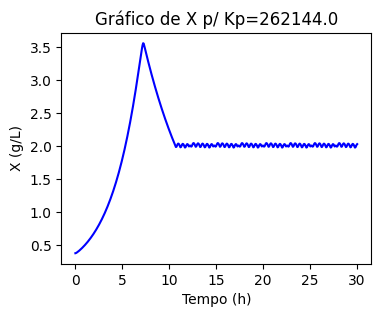

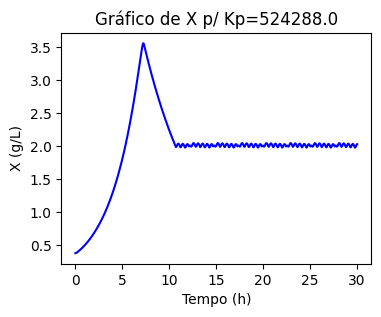

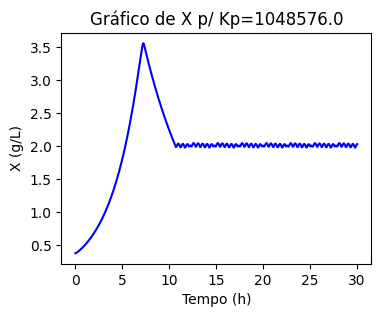

In [27]:
initial_x = 0.38
initial_s = 0.05

Kp_osc = 2.0
bioreactor = BioReactorSystem(0.17, 1.0, initial_x, initial_s) # Caso do sistema 1
pid_x_osc = PID(Kp_osc, 0.0, 0.0, output_limits=(0, 20), sample_time=0.05) # Valor inicial de Kp = 2.0

x_values = []
j = 0
setpoint_x = 2.0
simulation_time = 30
current_value = np.array([0.0, 0.0])
time = np.linspace(0, simulation_time, 500)
while (j < 20):
    pid_x_osc.set_tunings(Kp_osc, 0.0, 0.0)
    for i in time:
        current_time = i

        error_x = setpoint_x - current_value[0]

        pid_x_output = pid_x_osc.update(error_x, current_time=current_time)

        current_value = bioreactor.update_system(0.17, pid_x_output, time[1])
        x_values.append(current_value[0])
    
    plt.figure(figsize=(4, 3))
    plt.title(f'Gráfico de X p/ Kp={Kp_osc}')
    plt.plot(time, x_values, color='blue')
    #plt.plot(time, x_output, color='red', linestyle='--')
    plt.xlabel('Tempo (h)')
    plt.ylabel('X (g/L)')
    plt.show()

    x_values.clear()
    pid_x_osc.reset()
    bioreactor.reset()
    Kp_osc *= 2.0
    j+=1

Alteração de Kp não causa oscilação sustentada, logo, o método do Ganho Último não é válido para esse sistema

# Algoritmo Genético para sintonia

 The best solution found:                                                                           
 [7.72464881 2.39053224 0.65969502 5.20530153 7.31483395 0.10751588]

 Objective function:
 0.8421050827111158


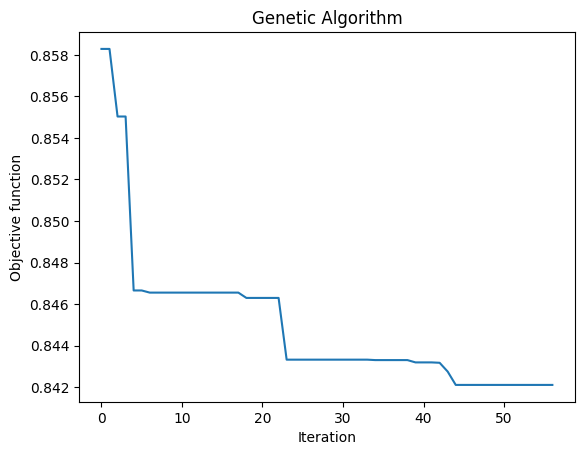


Optimal PID parameters: 
Kp_x=7.724648814377536, Ki_x=2.390532238983433, Kd_x=0.6596950168624893
Kp_s=5.205301527010467, Ki_s=7.314833954379044, Kd_s=0.10751587639697918


In [28]:
def fitness_function(X):
    setpoint_x = 1.0
    setpoint_s = 0.8
    initial_x = 0.38
    initial_s = 0.05
    
    # Creating the transfer function of the PID controller and the closed-loop system
    Kp_x, Ki_x, Kd_x, Kp_s, Ki_s, Kd_s = X
    
    # Parâmetros de tempo da simulação
    simulation_time = 20 # hours
    time = np.linspace(0, simulation_time, 1000)
    dt_simulation = time[1]

    pid_x_znrc = PID(Kp_x, Ki_x, Kd_x, output_limits=(0, 5.0), sample_time=dt_simulation)
    pid_s_znrc = PID(Kp_s, Ki_s, Kd_s, output_limits=(0.01, 0.45), sample_time=dt_simulation)
    bioreactor = BioReactorSystem(0.17, 1.0, initial_x, initial_s) # Caso do sistema 1

    # Parâmetros da simulação
    x_values = []
    s_values = []
    
    x_output = []
    s_output = []

    error_x_list = []
    error_s_list = []

    current_values = np.array([0.0, 0.0])
    for i in time:
        current_time = i

        # Calcular o erro
        error_x = setpoint_x - current_values[0] # Erro em X => g/L de X desejado - g/L de X medido
        error_s = setpoint_s - current_values[1] # Erro em S => g/L de S desejado - g/L de S medido

        # Guarda os erros
        error_x_list.append(error_x)
        error_s_list.append(error_s)

        # Atualizar o PID e obter a saída de controle
        pid_x_output = pid_x_znrc.update(error_x, current_time=current_time)
        pid_s_output = pid_s_znrc.update(error_s, current_time=current_time)
        x_output.append(pid_x_output)
        s_output.append(pid_s_output)

        current_values = bioreactor.update_system(pid_s_output, pid_x_output, time[1])
        x_values.append(current_values[0])
        s_values.append(current_values[1])
    
    # Calculating ISE (Integral of Squared Error) to determine the fitness
    error_x_list = np.array(error_x_list)
    error_s_list = np.array(error_s_list)
    
    dt = time[1]
    ise_x = np.sum(error_x_list**2) * dt
    ise_s = np.sum(error_s_list**2) * dt

    # Final fitness score calculation
    fitness_score = ise_x + ise_s
    
    return fitness_score

# Parameters for the genetic algorithm
algorithm_param = {
    'max_num_iteration': 1000,
    'population_size': 100,
    'mutation_probability': 0.3,
    'elit_ratio': 0.01,
    'crossover_probability': 0.3,
    'parents_portion': 0.3,
    'crossover_type': 'uniform',
    'max_iteration_without_improv': 10
}

varbound = np.array([
    [0.0, 8.0],  # Kp_x limits
    [0.0, 10.0],  # Ki_x limits
    [0.0, 5.0],   # Kd_x limits
    [0.0, 7.0],  # Kp_s limits
    [0.0, 10.0],  # Ki_s limits
    [0.0, 2.0]   # Kd_s limits
])

# creating the models for genetic algorithm
model = ga(
    function=fitness_function,
    dimension=6,
    variable_type='real',
    variable_boundaries=varbound,
    algorithm_parameters=algorithm_param,
    function_timeout=10
)

model.run()
best_score = model.best_function
Kp_x_optimal, Ki_x_optimal, Kd_x_optimal, Kp_s_optimal, Ki_s_optimal, Kd_s_optimal = model.best_variable
print(f"Best fitness score: {best_score}")
print(f"Optimal PID parameters: \nKp_x={Kp_x_optimal}, Ki_x={Ki_x_optimal}, Kd_x={Kd_x_optimal}\nKp_s={Kp_s_optimal}, Ki_s={Ki_s_optimal}, Kd_s={Kd_s_optimal}")

In [29]:
# Parâmetros de tempo
simulation_time = 20 # hours
time = np.linspace(0, simulation_time, 1000)
dt_simulation = time[1]

# Creating the transfer function of the PID controller and the closed-loop system
pid_x_ga = PID(Kp_x_optimal, Ki_x_optimal, 0.0, output_limits=(0, 5.0), sample_time=dt_simulation)
pid_s_ga = PID(Kp_s_optimal+2, Ki_s_optimal, 0.0, output_limits=(0.01, 0.45), sample_time=dt_simulation)
bioreactor_ga = BioReactorSystem(0.17, 1.0, initial_x, initial_s) # Caso do sistema 1

Simulação concluída para X. Valor final do sistema: 1.00
Simulação concluída para S. Valor final do sistema: 0.80


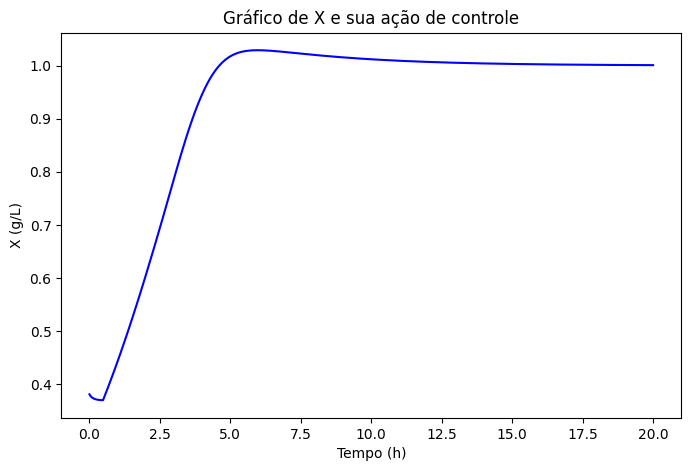

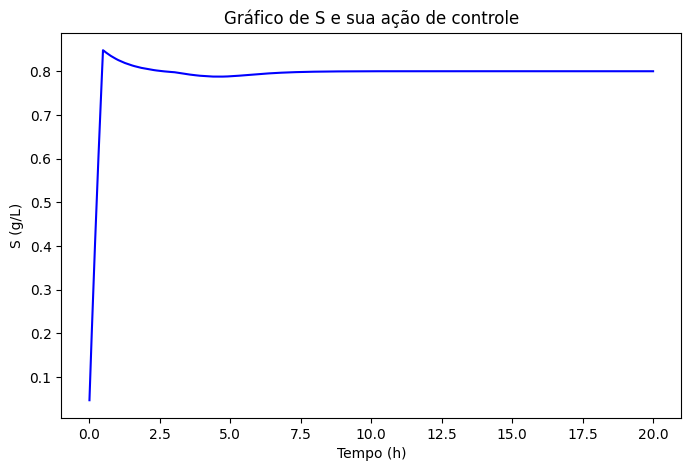

In [30]:
# Resets dos estados 
bioreactor_ga.reset()
pid_x_ga.reset()
pid_s_ga.reset()

# Definição dos setpoints
setpoint_x = 1.0
setpoint_s = 0.8

# Parâmetros da simulação
x_values = []
s_values = []
x_output = []
s_output = []

error_x_list = []
error_s_list = []

current_values = np.array([0.0, 0.0])
for i in time:
    current_time = i

    # Calcular o erro
    error_x = setpoint_x - current_values[0] # Erro em X => g/L de X desejado - g/L de X medido
    error_s = setpoint_s - current_values[1] # Erro em S => g/L de S desejado - g/L de S medido

    # Guarda os erros
    error_x_list.append(error_x)
    error_s_list.append(error_s)

    # Atualizar o PID e obter a saída de controle
    pid_x_output = pid_x_ga.update(error_x, current_time=current_time)
    pid_s_output = pid_s_ga.update(error_s, current_time=current_time)
    x_output.append(pid_x_output)
    s_output.append(pid_s_output)

    current_values = bioreactor_ga.update_system(pid_s_output, pid_x_output, time[1])
    x_values.append(current_values[0])
    s_values.append(current_values[1])


print(f"Simulação concluída para X. Valor final do sistema: {current_values[0]:.2f}")
print(f"Simulação concluída para S. Valor final do sistema: {current_values[1]:.2f}")

plt.figure(figsize=(8, 5))
plt.title('Gráfico de X e sua ação de controle')
plt.plot(time, x_values, color='blue')
#plt.plot(time, x_output, color='red', linestyle='--')
plt.xlabel('Tempo (h)')
plt.ylabel('X (g/L)')
plt.show()

plt.figure(figsize=(8, 5))
plt.title('Gráfico de S e sua ação de controle')
plt.plot(time, s_values, color='blue')
#plt.plot(time, s_output, color='red', linestyle='--')
plt.xlabel('Tempo (h)')
plt.ylabel('S (g/L)')
plt.show()

In [31]:
x_metrics_ga = param_performance(1.0, 0.38, x_values, time)
s_metrics_ga = param_performance(0.8, 0.05, s_values, time)

print(f'Métricas de S:\nSSE {x_metrics_ga['SSE']:.5f}\nISE {x_metrics_ga['ISE']:.2f}\nt_rise {x_metrics_ga['rise_time']:.2f}\nOvershoot {x_metrics_ga['overshoot']:.2f}%\nt_s {x_metrics_ga['settling_time']:.2f}')
print(f'\nMétricas de S:\nSSE {s_metrics_ga['SSE']:.5f}\nISE {s_metrics_ga['ISE']:.2f}\nt_rise {s_metrics_ga['rise_time']:.2f}\nOvershoot {s_metrics_ga['overshoot']:.2f}%\nt_s {s_metrics_ga['settling_time']:.2f}')

Métricas de S:
SSE -0.00077
ISE 0.36
t_rise 3.66
Overshoot 2.89%
t_s 7.97

Métricas de S:
SSE -0.00001
ISE 0.04
t_rise 0.38
Overshoot 6.02%
t_s 1.36


Controlador com distúrbio na leitura do sinal

Simulação concluída para X. Valor final do sistema: 1.00
Simulação concluída para S. Valor final do sistema: 0.80


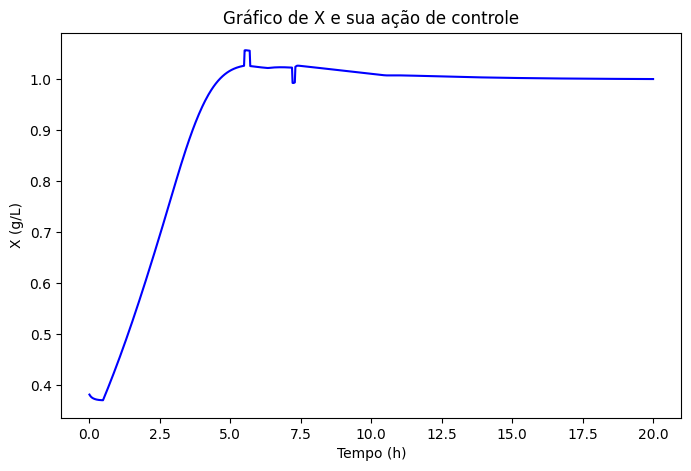

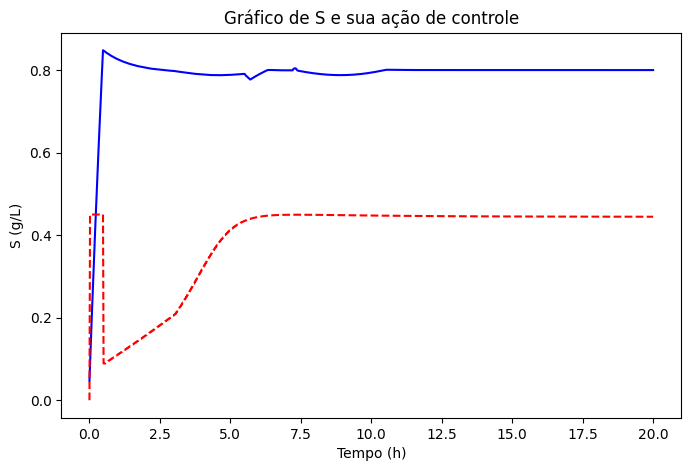

In [32]:
# Resets dos estados 
bioreactor_ga.reset()
pid_x_ga.reset()
pid_s_ga.reset()

# Parâmetros da simulação
x_values_dist = []
s_values_dist = []
x_output_dist = []
s_output_dist = []

dist_control = False
dist_start_1 = 5.5 # Hora inicial do distúrbio
dist_end_1 = 5.7 # Hora final do distúrbio

dist_start_2 = 7.2 # Hora inicial do distúrbio
dist_end_2 = 7.3 # Hora final do distúrbio

current_values = np.array([0.0, 0.0])
for i in time:
    current_time = i

    # Calcular o erro
    error_x = setpoint_x - current_values[0] # Erro em X => g/L de X desejado - g/L de X medido
    error_s = setpoint_s - current_values[1] # Erro em S => g/L de S desejado - g/L de S medido

    # Atualizar o PID e obter a saída de controle
    pid_x_output = pid_x_ga.update(error_x, current_time=current_time)
    pid_s_output = pid_s_ga.update(error_s, current_time=current_time)
    x_output_dist.append(pid_x_output)
    s_output_dist.append(pid_s_output)

    # Distúrbios
    if dist_control==True and (current_time >= dist_start_1 and current_time <= dist_end_1):
        pid_x_output += 0.2 # Distúrbio na ação de controle de X (Alteração no valor de Sf)
        current_values = bioreactor_ga.update_system(pid_s_output, pid_x_output, time[1])  
    elif dist_control==True and (current_time >= dist_start_2 and current_time <= dist_end_2):
        pid_x_output -= 0.5 # Distúrbio na ação de controle de X (Alteração no valor de Sf)
        current_values = bioreactor_ga.update_system(pid_s_output, pid_x_output, time[1])
    else:
        current_values = bioreactor_ga.update_system(pid_s_output, pid_x_output, time[1])

    if dist_control == False and (current_time >= dist_start_1 and current_time <= dist_end_1):
        current_values[0] += 0.03 # Distúrbio na leitura de X
    if dist_control == False and (current_time >= dist_start_2 and current_time <= dist_end_2):
        current_values[0] -= 0.03 # Distúrbio na leitura de X
    
    x_values_dist.append(current_values[0])
    s_values_dist.append(current_values[1])


print(f"Simulação concluída para X. Valor final do sistema: {current_values[0]:.2f}")
print(f"Simulação concluída para S. Valor final do sistema: {current_values[1]:.2f}")

plt.figure(figsize=(8, 5))
plt.title('Gráfico de X e sua ação de controle')
plt.plot(time, x_values_dist, color='blue')
#plt.plot(time, x_output, color='red', linestyle='--')
plt.xlabel('Tempo (h)')
plt.ylabel('X (g/L)')
plt.show()

plt.figure(figsize=(8, 5))
plt.title('Gráfico de S e sua ação de controle')
plt.plot(time, s_values_dist, color='blue')
plt.plot(time, s_output, color='red', linestyle='--')
plt.xlabel('Tempo (h)')
plt.ylabel('S (g/L)')
plt.show()

# Método Cascata

In [33]:
# Function to obtain the parameters Kp, tau, and theta from the step response of a transfer function
def get_params_cascade(U0, Uf, outer_values, time, degrau, atraso):
    # Simulação do step de X por D
    tempo_deg = np.where(time >= degrau)[0][0]
    x_resp = outer_values[tempo_deg:]

    # Valor de Kp
    x_initial = x_resp[0]
    delta_x = x_resp[-1] - x_initial # Supoẽ que o sistema chegou no regime estacionário

    # Determinação de Kp para análise de X
    K_x = (delta_x)/(Uf - U0)
    
    # Cálculo do theta
    theta_x = 0.0
    threshold = 0.02 # 2%
    x_condition = x_initial + threshold*delta_x
    indices = np.where(x_resp >= x_condition)[0]
    theta_x = time[tempo_deg + indices[0]] - time[tempo_deg] + atraso
    print(time[tempo_deg+indices[0]])

    # Cálculo de tau
    tau_x = 0.0
    x_initial = x_resp[indices[0]]
    indices_tau = np.where(x_resp >= (x_initial + 0.632*delta_x))[0]
    tau_x = time[tempo_deg + indices_tau[0]] - time[tempo_deg] + atraso
    print(time[tempo_deg + indices_tau[0]])

    return np.array([K_x, tau_x, theta_x])

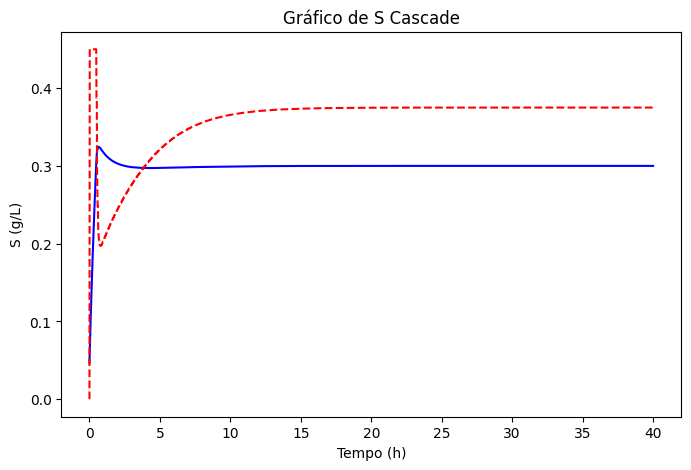

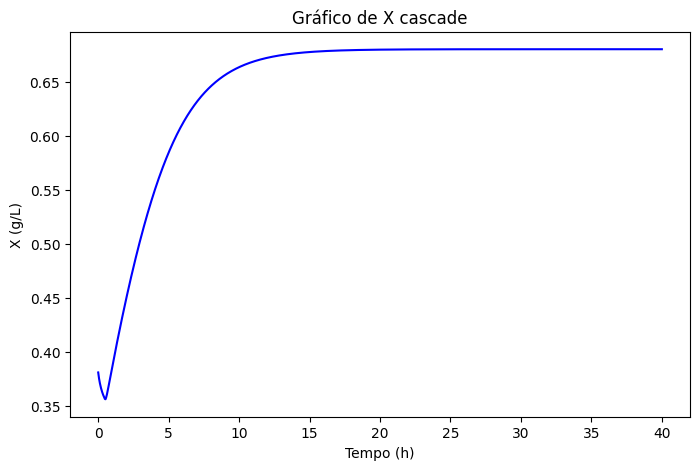

In [34]:
''' 
Para modelar o problema como um caso de cascata, pensei em deixar o valor de Sf constante e transformar o sistema de um MISO.
Logo, o controle é feito somente pelo valor de D que é controlado pelo PID interno para deixar S fixo no valor pedido pelo PID externo
que controla a quantidade de X.

Tem-se, portanto que o objetivo de controle é a quantidade de X.
'''
time = np.linspace(0, 40, 2000)

Sf = 2.0 # Constante
cascade_system = BioReactorSystem(0.17, Sf, 0.38, 0.05) # Caso 1 considerado na tese

inner_sp = 0.3 # 0.8 g/L
inner_params = [Kp_s_optimal, Ki_s_optimal] # Como fazer o tuning desse controlador interno (segue o mesmo tuning feito por genético ou algo assim?)
inner_pid = PID(inner_params[0]+2, inner_params[1], 0.0, output_limits=(0.01, 0.45), sample_time=time[1])

current_time = 0
inner_output_plot = []
inner_value_plot = []
outer_value_plot = []
current_values = np.array([0.0, 0.0])
for t in time:
    current_time = t

    inner_sp = 0.3

    '''if t < 20.0:
        inner_sp = 0.15
    else:
        inner_sp = 0.17'''

    inner_error = inner_sp - current_values[1]

    inner_output = inner_pid.update(inner_error, current_time)
    inner_output_plot.append(inner_output)

    current_values = cascade_system.update_system(D_pid=inner_output, Sf_pid=Sf, dt_simulation=time[1])
    inner_value_plot.append(current_values[1])
    outer_value_plot.append(current_values[0])

plt.figure(figsize=(8, 5))
plt.title('Gráfico de S Cascade')
plt.plot(time, inner_value_plot, color='blue')
plt.plot(time, inner_output_plot, color='red', linestyle='--')
plt.xlabel('Tempo (h)')
plt.ylabel('S (g/L)')
plt.show()

plt.figure(figsize=(8, 5))
plt.title('Gráfico de X cascade')
plt.plot(time, outer_value_plot, color='blue')
# plt.plot(time, inner_output_plot, color='red', linestyle='--')
plt.xlabel('Tempo (h)')
plt.ylabel('X (g/L)')
plt.show()

In [35]:
outer_params_cascade = get_params_cascade(0.0, 0.3, outer_value_plot, time, degrau=0.0, atraso=0.5) # Atraso de 0.3h
intermediate_params = imc_tuning(outer_params_cascade[0], outer_params_cascade[1], outer_params_cascade[2], lambda_imc=5.0)
outer_params = determine_pid_params(intermediate_params[0], intermediate_params[1], intermediate_params[2])

print(outer_params_cascade[0],'\n', outer_params_cascade[1], '\n', outer_params_cascade[2])
print(f'Valores de Kp, Ki e Kd para o controlador de X Cascade\nKp={outer_params[0]}, Ki={outer_params[1]} e Kd={outer_params[2]}')

1.0205102551275638
4.762381190595297
0.9958574943579052 
 5.262381190595297 
 1.5205102551275638
Valores de Kp, Ki e Kd para o controlador de X Cascade
Kp=0.8104076379872034, Ki=0.1540001776069604 e Kd=0.0


In [36]:
time = np.linspace(0, simulation_time, 1000)
dt_simulation = time[1]

outer_sp = 1.0 
outer_pid = PID(outer_params[0], outer_params[1], 0.0, output_limits=(0.01, 5.0), sample_time=dt_simulation)

Sf = 2.0 # Constante
cascade_system = BioReactorSystem(0.17, Sf, 0.38, 0.05) # Caso 1 considerado na tese

inner_params = [Kp_s_optimal, Ki_s_optimal] # Como fazer o tuning desse controlador interno (segue o mesmo tuning feito por genético ou algo assim?)
inner_pid = PID(inner_params[0], inner_params[1], 0.0, output_limits=(0.01, 0.45), sample_time=dt_simulation)

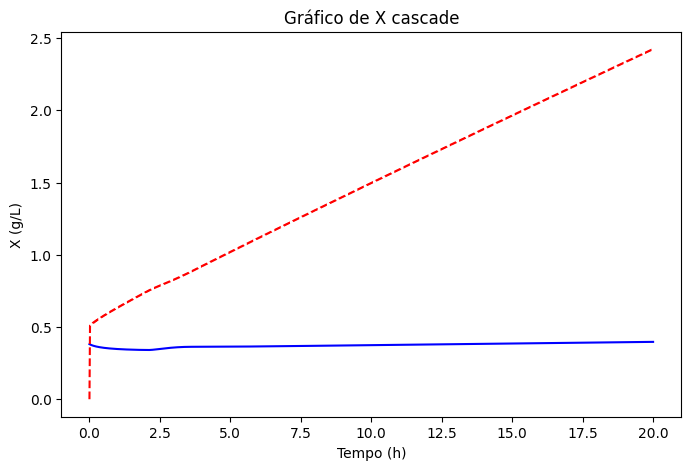

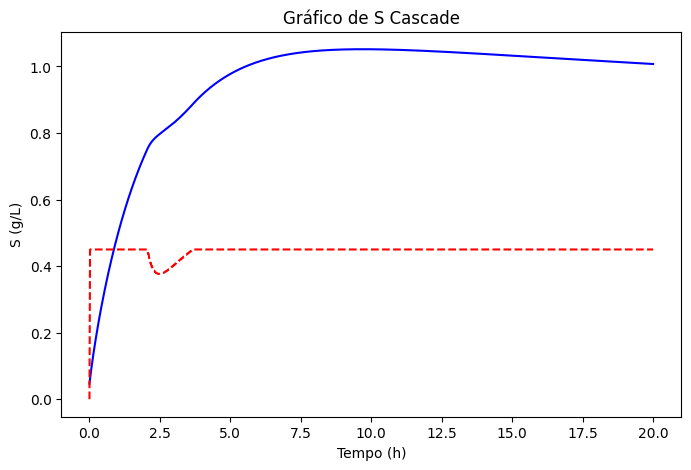

In [37]:
# Resets
cascade_system.reset()
outer_pid.reset()
inner_pid.reset()

# Guardar informações para os plots
inner_output_plot = []
inner_value_plot = []
outer_value_plot = []
outer_output_plot = []

current_time = 0
current_values = np.array([0.0, 0.0])
for t in time:
    current_time = t
    
    outer_error = outer_sp - current_values[0]
    outer_output = outer_pid.update(outer_error, current_time)
    outer_output_plot.append(outer_output)

    inner_error = outer_output - current_values[1] # Definição da saída de outer como setpoint de inner
    
    inner_output = inner_pid.update(inner_error, current_time)
    inner_output_plot.append(inner_output)

    current_values = cascade_system.update_system(D_pid=inner_output, Sf_pid=Sf, dt_simulation=dt_simulation)
    inner_value_plot.append(current_values[1])
    outer_value_plot.append(current_values[0])

plt.figure(figsize=(8, 5))
plt.title('Gráfico de X cascade')
plt.plot(time, outer_value_plot, color='blue')
plt.plot(time, outer_output_plot, color='red', linestyle='--')
plt.xlabel('Tempo (h)')
plt.ylabel('X (g/L)')
plt.show()

plt.figure(figsize=(8, 5))
plt.title('Gráfico de S Cascade')
plt.plot(time, inner_value_plot, color='blue')
plt.plot(time, inner_output_plot, color='red', linestyle='--')
plt.xlabel('Tempo (h)')
plt.ylabel('S (g/L)')
plt.show()

In [38]:
x_metrics_cascade = param_performance(1.0, 0.38, x_values, time)
s_metrics_cascade = param_performance(0.8, 0.05, s_values, time)

print(f'Métricas de S:\nSSE {x_metrics_ga['SSE']:.5f}\nISE {x_metrics_ga['ISE']:.2f}\nt_rise {x_metrics_ga['rise_time']:.2f}\nOvershoot {x_metrics_ga['overshoot']:.2f}%\nt_s {x_metrics_ga['settling_time']:.2f}')
print(f'\nMétricas de S:\nSSE {s_metrics_ga['SSE']:.5f}\nISE {s_metrics_ga['ISE']:.2f}\nt_rise {s_metrics_ga['rise_time']:.2f}\nOvershoot {s_metrics_ga['overshoot']:.2f}%\nt_s {s_metrics_ga['settling_time']:.2f}')

Métricas de S:
SSE -0.00077
ISE 0.36
t_rise 3.66
Overshoot 2.89%
t_s 7.97

Métricas de S:
SSE -0.00001
ISE 0.04
t_rise 0.38
Overshoot 6.02%
t_s 1.36


# Controlador Fuzzy

Estratégia de utilização do fuzzy: Dois controladores fuzzy desacoplados (ideia inicial)

Entradas para a membership function: erros e ações de controle anterior 

Saídas após a deffuzificação: valor da ação de controle dos controladores

In [39]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl

/home/miguel/Estudo/Sistemas Inteligentes de Controle/.venv/lib/python3.12/site-packages/skfuzzy/control/fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


[]

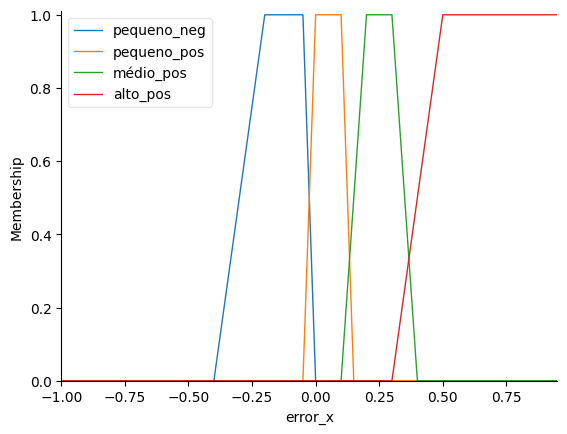

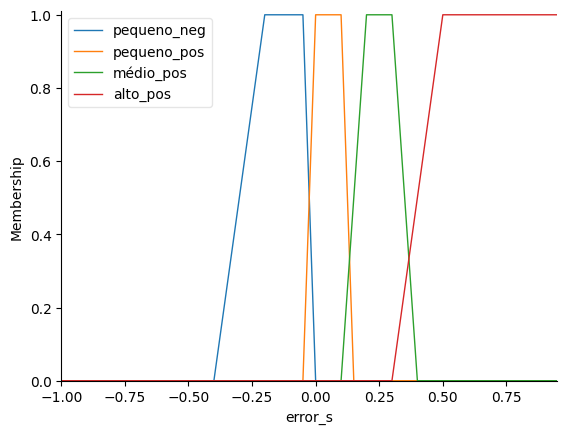

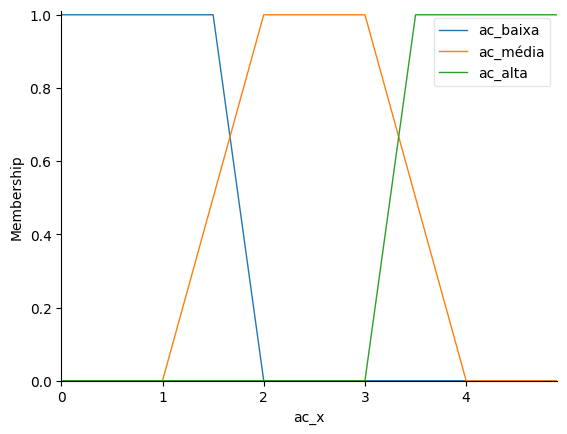

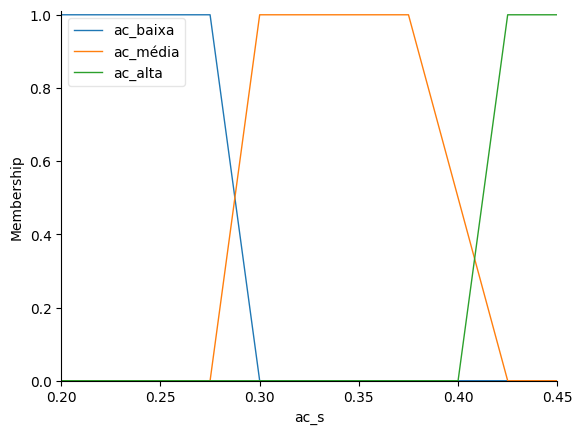

In [40]:
''' 
Determinação das entradas e classes

Entradas:
erro_x = [-1.0, 1.0] (Chute inicial, ainda não sei qual o melhor ou se existe um processo para definir isso)
erro_y (Vou começar com os erros iguais)
ac_x_ant = [0.01, 5.0]
ac_s_ant = [0.01, 0.45]

Saídas:
ac_x = [0.01, 5.0] (Começar com valor de 5 g/L de injeção máxima)
ac_y = [0.01, 0.45] (0.45 padrão que utilizo nos outros controladores)

'''
# Definição das entradas dos controladores fuzzy
error_x = ctrl.Antecedent(np.arange(-1.0, 1.0, 0.05), 'error_x')
error_s = ctrl.Antecedent(np.arange(-1.0, 1.0, 0.05), 'error_s')

ac_x_ant = ctrl.Antecedent(np.arange(0.01, 5.0, 0.1), 'ac_x_ant')
ac_s_ant = ctrl.Antecedent(np.arange(0.01, 0.45, 0.05), 'ac_s_ant') # Por enquanto sem necessidade

# Definição das saídas dos controladores fuzzy
ac_x = ctrl.Consequent(np.arange(0.0, 5.0, 0.1), 'ac_x')
ac_s = ctrl.Consequent(np.arange(0.20, 0.475, 0.025), 'ac_s')

# Definição das membership functions de entrada
'''error_x['alto_neg'] = fuzz.trapmf(error_x.universe, [-1.0, -1.0, -0.8, -0.6])
error_x['médio_neg'] = fuzz.trapmf(error_x.universe, [-0.8, -0.6, -0.4, -0.2])'''
error_x['pequeno_neg'] = fuzz.trapmf(error_x.universe, [-0.4, -0.2, 0.0, 0.0])
error_x['pequeno_pos'] = fuzz.trapmf(error_x.universe, [0.0, 0.0, 0.1, 0.15])
error_x['médio_pos'] = fuzz.trapmf(error_x.universe, [0.1, 0.2, 0.3, 0.4])
error_x['alto_pos'] = fuzz.trapmf(error_x.universe, [0.3, 0.5, 1.0, 1.0])

'''error_s['alto_neg'] = fuzz.trapmf(error_s.universe, [-1.0, -1.0, -0.8, -0.6])
error_s['médio_neg'] = fuzz.trapmf(error_s.universe, [-0.8, -0.6, -0.4, -0.2])'''
error_s['pequeno_neg'] = fuzz.trapmf(error_s.universe, [-0.4, -0.2, 0.0, 0.0])
error_s['pequeno_pos'] = fuzz.trapmf(error_s.universe, [0.0, 0.0, 0.1, 0.15])
error_s['médio_pos'] = fuzz.trapmf(error_s.universe, [0.1, 0.2, 0.3, 0.4])
error_s['alto_pos'] = fuzz.trapmf(error_s.universe, [0.3, 0.5, 1.0, 1.0])

ac_x_ant['ac_ant_baixa'] = fuzz.trimf(ac_x_ant.universe, [0.01, 0.01, 2.5])
ac_x_ant['ac_ant_média'] = fuzz.trimf(ac_x_ant.universe, [0.01, 2.5, 5.0])
ac_x_ant['ac_ant_alta'] = fuzz.trimf(ac_x_ant.universe, [2.5, 5.0, 5.0])

ac_s_ant['ac_ant_baixa'] = fuzz.trimf(ac_s_ant.universe, [0.01, 0.01, 0.15])
ac_s_ant['ac_ant_média'] = fuzz.trimf(ac_s_ant.universe, [0.01, 0.225, 0.45])
ac_s_ant['ac_ant_alta'] = fuzz.trimf(ac_s_ant.universe, [0.30, 0.45, 0.45])

# Definição das membership functions de saída
ac_x['ac_baixa'] = fuzz.trapmf(ac_x.universe, [0.0, 0.0, 1.5, 2.0])
ac_x['ac_média'] = fuzz.trapmf(ac_x.universe, [1.0, 2.0, 3.0, 4.0])
ac_x['ac_alta'] = fuzz.trapmf(ac_x.universe, [3.0, 3.5, 5.0, 5.0])

ac_s['ac_baixa'] = fuzz.trapmf(ac_s.universe, [0.20, 0.20, 0.275, 0.30])
ac_s['ac_média'] = fuzz.trapmf(ac_s.universe, [0.275, 0.3, 0.375, 0.425])
ac_s['ac_alta'] = fuzz.trapmf(ac_s.universe, [0.40, 0.425, 0.45, 0.45])

error_x.view()
error_s.view()
ac_x.view()
ac_s.view()
plt.plot()

In [41]:
''' Criação das regras de fuzzificação 
Regras básicas = Primeira tentativa com correspondência direta
'''

# Erros altos
reg1_x = ctrl.Rule(error_x['alto_pos'], ac_x['ac_alta'])
reg1_s = ctrl.Rule(error_s['alto_pos'], ac_s['ac_alta'])

# Erros baixo
reg2_x = ctrl.Rule(error_x['pequeno_pos'], ac_x['ac_baixa'])
reg2_s = ctrl.Rule(error_s['pequeno_pos'], ac_s['ac_baixa'])

# Erros médios
reg3_x = ctrl.Rule(error_x['médio_pos'], ac_x['ac_média'])
reg3_s = ctrl.Rule(error_s['médio_pos'], ac_s['ac_média'])

# Erros negativos
reg4_x = ctrl.Rule(error_x['pequeno_neg'], ac_x['ac_baixa'])
reg4_s = ctrl.Rule(error_s['pequeno_neg'], ac_s['ac_baixa'])

# Criação dos controladores e simuladores
fcontr_x = ctrl.ControlSystem([reg1_x, reg2_x, reg3_x, reg4_x])
fcontr_s = ctrl.ControlSystem([reg1_s, reg2_s, reg3_s, reg4_s])

sim_fcontr_x = ctrl.ControlSystemSimulation(fcontr_x)
sim_fcontr_s = ctrl.ControlSystemSimulation(fcontr_s)

In [42]:
''' Simulação do controlador Fuzzy com o sistema '''

simulation_time = 20
time = np.linspace(0, simulation_time, 1000)
dt_simulation = time[1]

x_setpoint = 1.0 
s_setpoint = 0.8
fuzzy_system = BioReactorSystem(0.17, 1.0, 0.38, 0.05) # Caso 1 considerado na tese

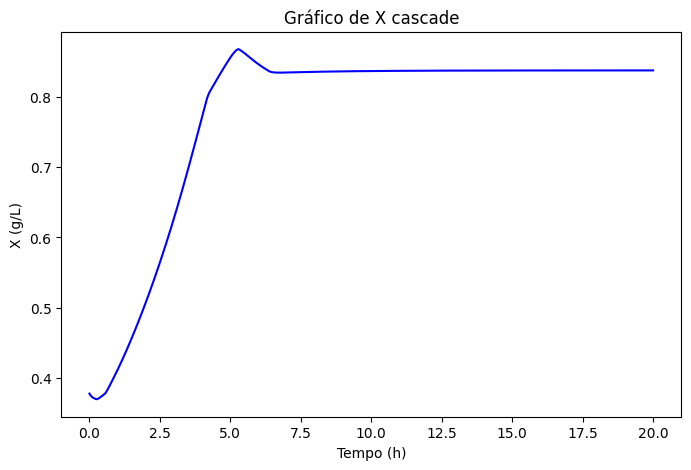

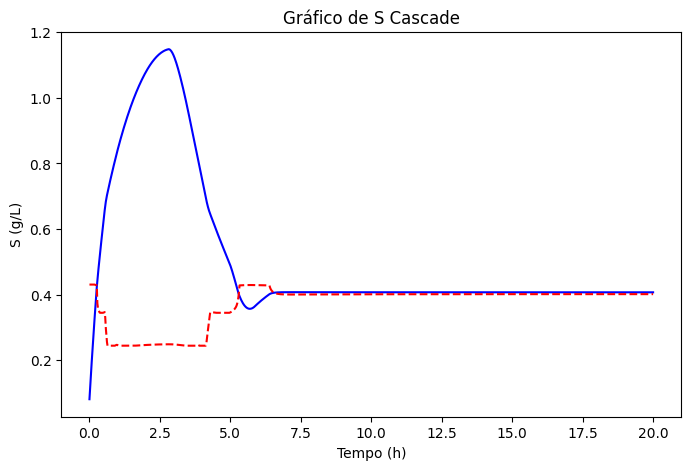

In [43]:
fuzzy_system.reset()

# Guardar informações para os plots
x_values = []
s_values = []
x_output = []
s_output = []

error_x_list = []
error_s_list = []

current_time = 0
current_values = np.array([0.0, 0.0])
for t in time:
    current_time = t
    
    error_x = x_setpoint - current_values[0]
    error_s = s_setpoint - current_values[1]
    error_x_list.append(error_x)
    error_s_list.append(error_s)

    sim_fcontr_x.input['error_x'] = error_x
    sim_fcontr_x.compute()
    sim_fcontr_s.input['error_s'] = error_s
    sim_fcontr_s.compute()

    ''' Ajustar os valores do controlador fuzzy do sistema '''

    x_ac = sim_fcontr_x.output['ac_x']
    x_output.append(x_ac)
    s_ac = sim_fcontr_s.output['ac_s']
    s_output.append(s_ac)

    current_values = fuzzy_system.update_system(D_pid=s_ac, Sf_pid=x_ac, dt_simulation=dt_simulation)
    x_values.append(current_values[0])
    s_values.append(current_values[1])

plt.figure(figsize=(8, 5))
plt.title('Gráfico de X cascade')
plt.plot(time, x_values, color='blue')
#plt.plot(time, x_output, color='red', linestyle='--')
plt.xlabel('Tempo (h)')
plt.ylabel('X (g/L)')
plt.show()

plt.figure(figsize=(8, 5))
plt.title('Gráfico de S Cascade')
plt.plot(time, s_values, color='blue')
plt.plot(time, s_output, color='red', linestyle='--') # s_output
plt.xlabel('Tempo (h)')
plt.ylabel('S (g/L)')
plt.show()

In [44]:
print(error_s_list)


[np.float64(0.8), np.float64(0.7192307979715968), np.float64(0.6895938524115945), np.float64(0.660821113541511), np.float64(0.6327489922137326), np.float64(0.6052694008706564), np.float64(0.5783066837912679), np.float64(0.5518055016623746), np.float64(0.5257239317996507), np.float64(0.5000292912934317), np.float64(0.47469548336136275), np.float64(0.44974614816318675), np.float64(0.4251644776211936), np.float64(0.4009360600564241), np.float64(0.3770483826767507), np.float64(0.3573884535273098), np.float64(0.33892667477064475), np.float64(0.3211270459296328), np.float64(0.30383484083090345), np.float64(0.2869751784344696), np.float64(0.2703366303060233), np.float64(0.25386319087502807), np.float64(0.23755185622004638), np.float64(0.22139982324440444), np.float64(0.2054044670120191), np.float64(0.18956332114543806), np.float64(0.17383989568185), np.float64(0.15821219143522158), np.float64(0.14267604884165974), np.float64(0.1284710743396995), np.float64(0.11652342847128205), np.float64(0.1

# Estratégias de controle inteligente

1 - Feedforward Control

2 - MPC ()

3 - Pole Placement

4 - LQR

5 - LQG

In [45]:
# Feedforward bioreactor
bioreactor_feedforward = BioReactorSystem(0.17, 1.0, 0.38, 0.17)

Simulação concluída para X. Valor final do sistema: 1.00
Simulação concluída para S. Valor final do sistema: 0.80


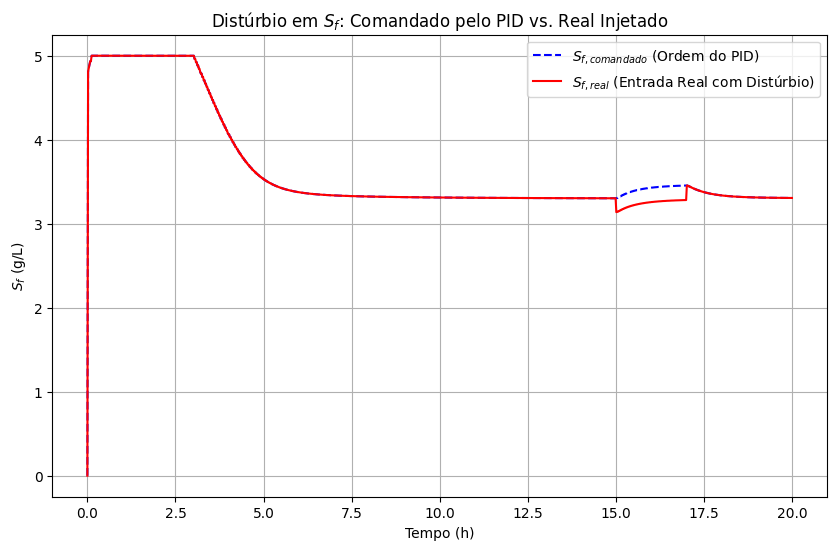

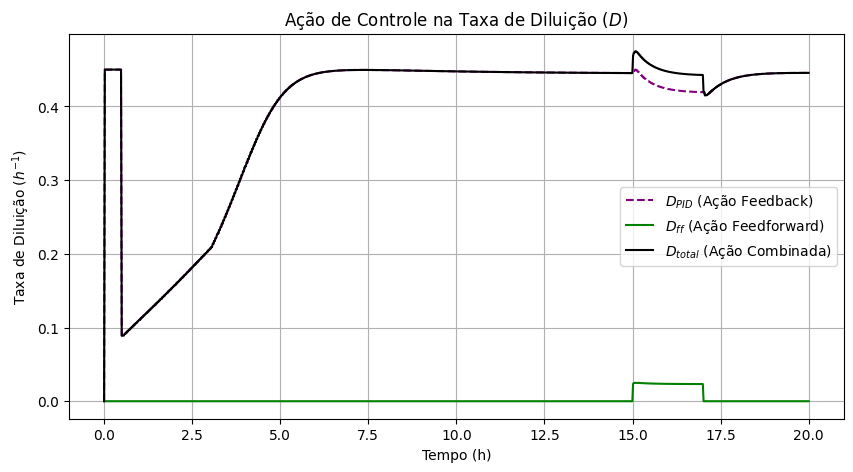

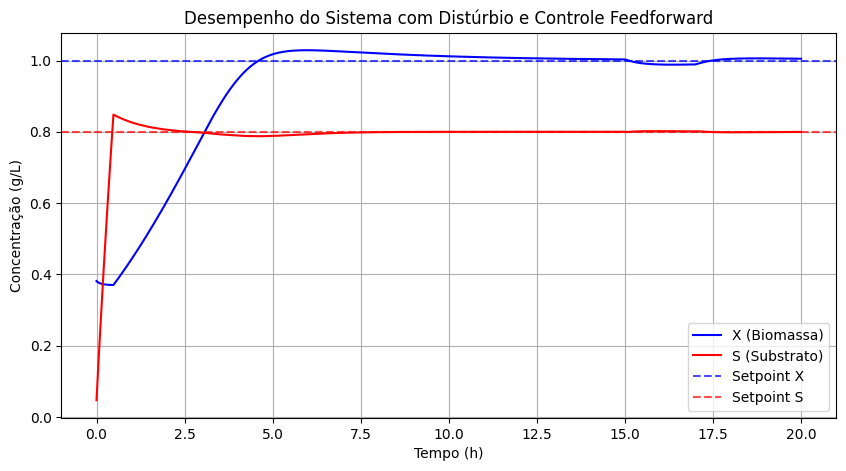

In [46]:
# Configuração do Distúrbio Externo
tempo_perturbacao = 15  # Tempo perturbação inicial
fator_perturbacao = 0.95 # Fator de erro, quanto vai baixar do valor comandado

# Inicialização
d_last_total = 0.0 # Guarda o último valor total de D aplicado
d_ff_values = []   # Para plotar a ação do feedforward
sf_real_values = [] # Para plotar o S_f real que entra no reator

# Resets dos estados 
bioreactor_ga.reset()
pid_x_ga.reset()
pid_s_ga.reset()

# Definição dos setpoints
setpoint_x = 1.0
setpoint_s = 0.8

# Parâmetros da simulação
x_values = []
s_values = []
sf_comandado_values = [] # Ação de controle para X (S_f comandado pelo PID)
d_pid_output = []       # Ação de controle para S (D comandado pelo PID)

error_x_list = []
error_s_list = []

current_values = np.array([0.0, 0.0])
for i in time:
    current_time = i

    # Calcular o erro
    error_x = setpoint_x - current_values[0] 
    error_s = setpoint_s - current_values[1] 

    # Guarda os erros
    error_x_list.append(error_x)
    error_s_list.append(error_s)

    # 1. Obter o comando do PID de X (o valor IDEAL de S_f)
    s_f_comandado = pid_x_ga.update(error_x, current_time=current_time)
    sf_comandado_values.append(s_f_comandado)

    # Obter o comando do PID de S
    pid_s_output = pid_s_ga.update(error_s, current_time=current_time)
    d_pid_output.append(pid_s_output)

    # 2. Simular o Distúrbio: o S_f REAL é uma versão "corrompida" do comando
    s_f_real = s_f_comandado
    if current_time >= tempo_perturbacao and current_time <= tempo_perturbacao + 2:
        s_f_real = s_f_comandado * fator_perturbacao
    sf_real_values.append(s_f_real)

    # 3. Calcular a Ação de Controle Feedforward
    # O feedforward compara o que foi comandado com o que realmente entrou
    # Modelo: D_ff = D_antigo * (S_f_comandado / S_f_real - 1)
    if s_f_real > 1e-6: # Evita divisão por zero
        d_ff = d_last_total * (s_f_comandado / s_f_real - 1) 
        ''' Tenho que entender melhor as outras técnicas para fazer o cálculo da ação de Feedforward '''
    else:
        d_ff = 0
    d_ff_values.append(d_ff)

    # 4. Combinar Feedback + Feedforward para a taxa de diluição
    d_total = pid_s_output + d_ff
    '''if d_total > 0.45:
        d_total = 0.45'''

    ''' 
    
    Por enquanto vou deixar sem a restrição do valor máximo do atuador pois ele apresenta um comportamento muito melhor sem.
    Talvez eu tenha que aumentar o valor do atuador para o 0.50 em todos os casos, não limitá-lo ao 0.45
    
    '''

    # 5. Atualizar o Sistema com os valores REAIS
    # O sistema é afetado pela taxa de diluição total (d_total) e pelo
    # substrato que de fato entrou (s_f_real).
    current_values = bioreactor_ga.update_system(d_total, s_f_real, time[1])
    x_values.append(current_values[0])
    s_values.append(current_values[1])
    
    # Atualiza o valor de D para o próximo cálculo do feedforward
    d_last_total = d_total


print(f"Simulação concluída para X. Valor final do sistema: {current_values[0]:.2f}")
print(f"Simulação concluída para S. Valor final do sistema: {current_values[1]:.2f}")

# --- Gráficos para Análise ---

# Gráfico da Perturbação: Comandado vs. Real
plt.figure(figsize=(10, 6))
plt.title('Distúrbio em $S_f$: Comandado pelo PID vs. Real Injetado')
plt.plot(time, sf_comandado_values, color='blue', linestyle='--', label='$S_{f,comandado}$ (Ordem do PID)')
plt.plot(time, sf_real_values, color='red', label='$S_{f,real}$ (Entrada Real com Distúrbio)')
plt.xlabel('Tempo (h)')
plt.ylabel('$S_f$ (g/L)')
plt.grid(True)
plt.legend()
plt.show()

# Gráfico da Ação de Controle em S
plt.figure(figsize=(10, 5))
plt.title('Ação de Controle na Taxa de Diluição ($D$)')
plt.plot(time, d_pid_output, color='purple', linestyle='--', label='$D_{PID}$ (Ação Feedback)')
plt.plot(time, d_ff_values, color='green', label='$D_{ff}$ (Ação Feedforward)')
# Para plotar o D total, some as duas listas:
d_total_values = [pid + ff for pid, ff in zip(d_pid_output, d_ff_values)]
plt.plot(time, d_total_values, color='black', label='$D_{total}$ (Ação Combinada)')
plt.xlabel('Tempo (h)')
plt.ylabel('Taxa de Diluição ($h^{-1}$)')
plt.grid(True)
plt.legend()
plt.show()


# Gráfico do resultado final
plt.figure(figsize=(10, 5))
plt.title('Desempenho do Sistema com Distúrbio e Controle Feedforward')
plt.plot(time, x_values, color='blue', label='X (Biomassa)')
plt.plot(time, s_values, color='red', label='S (Substrato)')
plt.axhline(y=setpoint_x, color='blue', linestyle='--', alpha=0.7, label='Setpoint X')
plt.axhline(y=setpoint_s, color='red', linestyle='--', alpha=0.7, label='Setpoint S')
plt.xlabel('Tempo (h)')
plt.ylabel('Concentração (g/L)')
plt.legend()
plt.grid(True)
plt.show()

MPC utilizando a biblioteca python do-mpc

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      602
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      300

Total number of variables............................:      208
                     variables with only lower bounds:      152
                variables with lower and upper bounds:       40
                     variables with only upper bounds:        0
Total number of equality constraints.................:      162
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0145207e+01 1.52e-02 9.46e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

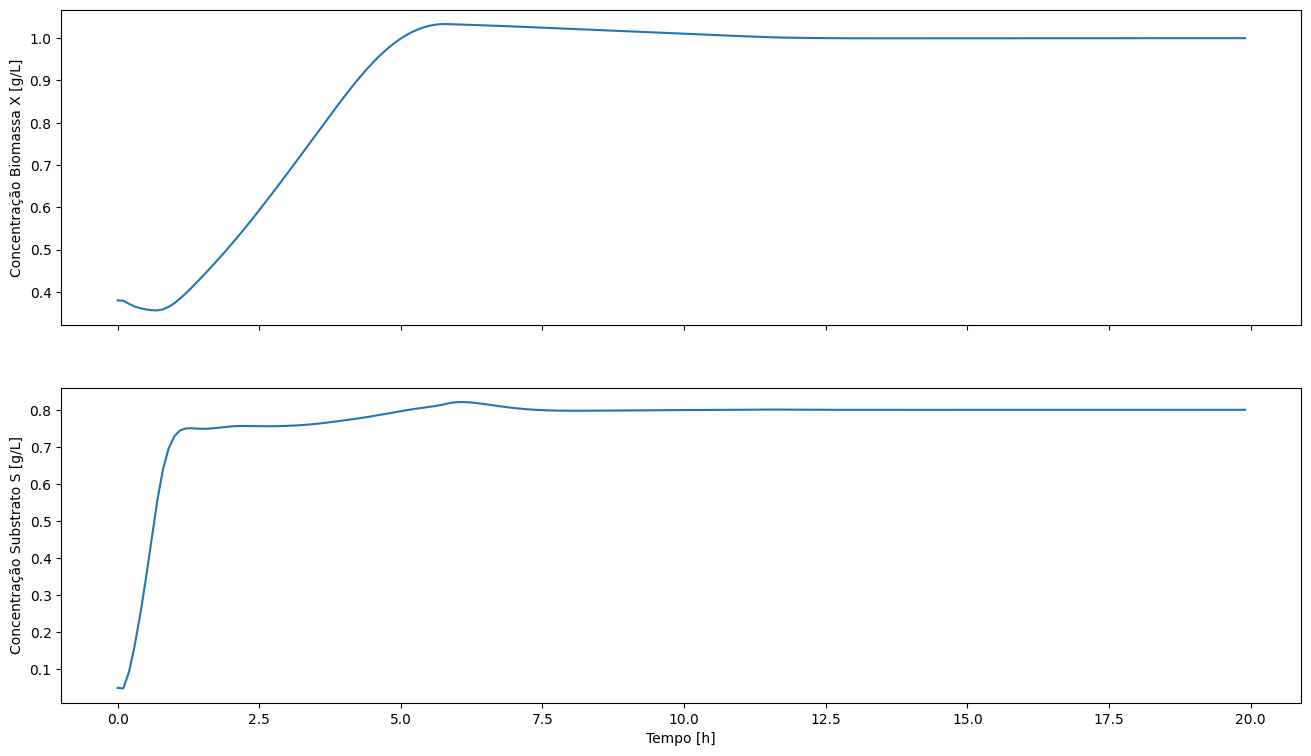

"# Cria um objeto gráfico com os dados do MPC e do Simulador\ngraph = Graphics(mpc.data, simulator.data)\n\n# --- Gráfico 1: Estados (X e S) vs. Setpoints ---\nfig, ax = plt.subplots(2, sharex=True, figsize=(16,9))\nfig.suptitle('Desempenho do Controle MPC: Estados do Sistema')\nax[0].set_ylabel('Biomassa X [g/L]')\nax[1].set_ylabel('Substrato S [g/L]')\nax[1].set_xlabel('Tempo [h]')\n\n# Adiciona as linhas dos estados (do simulador) aos eixos\ngraph.add_line(var_type='_x', var_name='X', axis=ax[0])\ngraph.add_line(var_type='_x', var_name='S', axis=ax[1])\n\n# Adiciona as linhas dos setpoints (constantes)\nax[0].axhline(1.0, color='r', linestyle='--', label='Setpoint X')\nax[1].axhline(0.8, color='g', linestyle='--', label='Setpoint S')\n\n# Renderiza o gráfico\ngraph.plot_results()\nax[0].legend()\nax[1].legend()\nax[0].grid(True)\nax[1].grid(True)\n\n\n# --- Gráfico 2: Ações de Controle (D e Sf) ---\nfig, ax = plt.subplots(2, sharex=True, figsize=(16,9))\nfig.suptitle('Desempenho do 

In [ ]:
"""
Passo 1: Definição do Modelo Não linear do Biorreator
"""
model = Model('continuous')

# Estados do modelo
X = model.set_variable(var_type='_x', var_name='X', shape=(1,1))
S = model.set_variable(var_type='_x', var_name='S', shape=(1,1))

# Entradas (variáveis de controle)
Sf = model.set_variable(var_type='_u', var_name='Sf')
D = model.set_variable(var_type='_u', var_name='D')

# Parâmetros físicos do modelo
mi_max = 0.5
K_s = 0.1
Y = 0.4

# Setpoints
X_sp = 1.0 # g/L
S_sp = 0.8 # g/L

# Equação da cinética de Monod com proteção para divisão por zero
mi = (mi_max*S)/(K_s + S)

# Equações diferenciais (lado direito da equação)
model.set_rhs('X', (mi - D)*X)
model.set_rhs('S', D*(Sf - S) - (mi*X/Y))

# Finaliza a configuração do modelo
model.setup()

"""
Passo 2: Configuração do Controlador MPC
"""
mpc = MPC(model)

dt_simulation = 0.1

setup_mpc = {
    'n_horizon': 20,
    't_step': dt_simulation,
    'n_robust': 1,
    'store_full_solution': True,
}
mpc.set_param(**setup_mpc)

# Função de custo
lterm = (X - X_sp)**2 + (S - S_sp)**2
mterm = lterm
mpc.set_objective(mterm=mterm, lterm=lterm)

# Peso sobre as entradas
mpc.set_rterm(D=1, Sf=1)

# Restrições
mpc.bounds['lower','_u', 'D'] = 0.01
mpc.bounds['upper','_u', 'D'] = 0.45
mpc.bounds['lower','_u', 'Sf'] = 0.5
mpc.bounds['upper','_u', 'Sf'] = 5.0
mpc.bounds['lower','_x', 'X'] = 0.0 # Não podem ser negativas
mpc.bounds['lower','_x', 'S'] = 0.0

mpc.setup()

"""
Passo 3: Configuração do Simulador
"""
simulator = Simulator(model)
simulator.set_param(t_step=dt_simulation)

# Função de parâmetros obrigatória
def p_fun(t):
    p_template = simulator.get_p_template()
    return p_template

simulator.set_p_fun(p_fun)
simulator.setup()

"""
Passo 4: Execução do Loop de Controle
"""
# Estado inicial
x0 = np.array([0.38, 0.05]).reshape(-1, 1) # Valores do caso 1 do artigo
simulator.x0 = x0
mpc.x0 = x0

# Configura a função para os setpoints
def tvp_fun(t):
    tvp_template = mpc.get_tvp_template()
    return tvp_template

mpc.set_tvp_fun(tvp_fun)
mpc.set_initial_guess()

# Loop principal
n_simulation_steps = 200
for i in range(n_simulation_steps):
    u0 = mpc.make_step(x0)
    x0 = simulator.make_step(u0)

"""
Passo 5: Visualização dos Resultados
"""
# Cria um objeto gráficos
sim_graphics = Graphics(simulator.data)

fig, ax = plt.subplots(2, sharex=True, figsize=(16,9))
fig.align_ylabels()

for g in [sim_graphics]: #, mpc_graphics
    # Plot de X e sua ação de controle
    g.add_line(var_type='_x', var_name='X', axis=ax[0])
    #g.add_line(var_type='_u', var_name='Sf', axis=ax[0])
    
    # Plot de S e sua ação de controle 
    g.add_line(var_type='_x', var_name='S', axis=ax[1])
    #g.add_line(var_type='_u', var_name='D', axis=ax[1])
    

ax[0].set_ylabel('Concentração Biomassa X [g/L]')
ax[1].set_ylabel('Concentração Substrato S [g/L]')
ax[1].set_xlabel('Tempo [h]')

plt.show()

LQR

Ponto de Operação Estacionário:
D_ss = 0.44 L/h, Sf_ss = 3.30 g/L
X_ss = 1.0267 g/L, S_ss = 0.7333 g/L

Matriz de Ganho LQR (K):
[[-0.67699377  0.72937325]
 [ 0.10608508  0.16746945]]


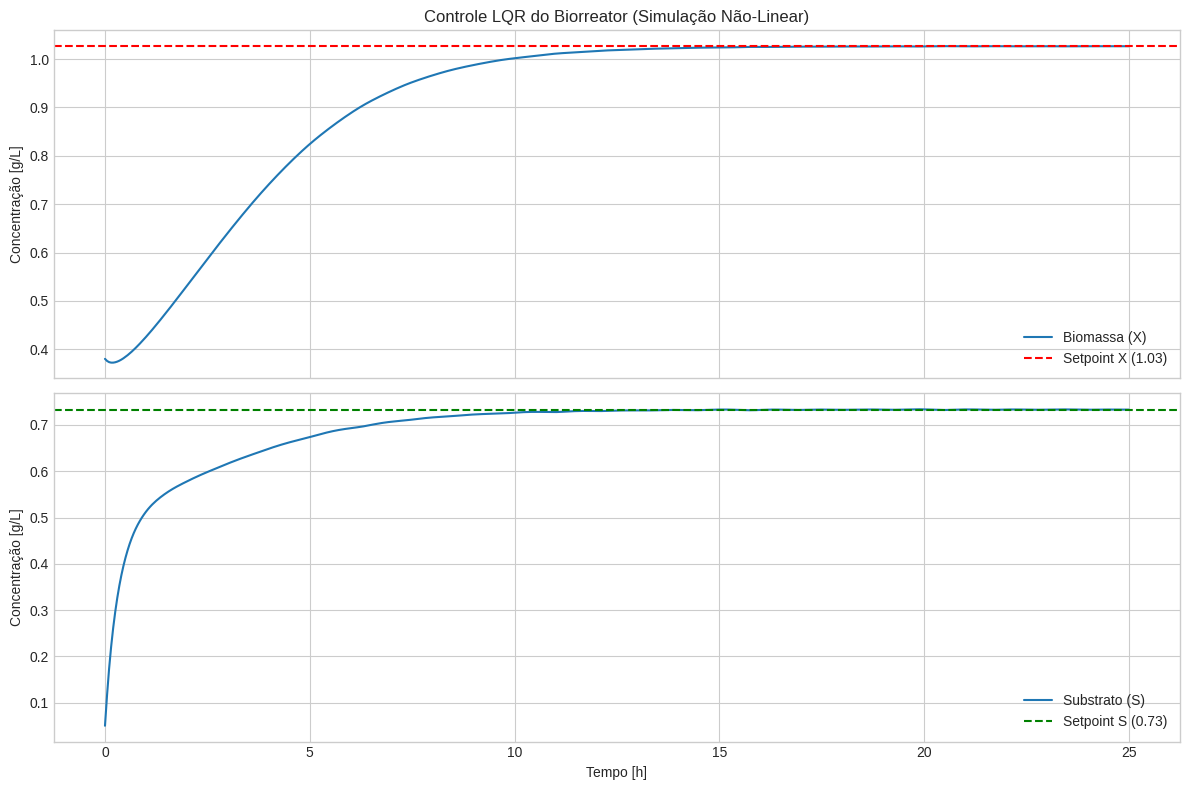

In [50]:
''' Definição do modelo linearizado '''

# Constantes do sistema
mi_max = 0.5
K_s = 0.1
Y = 0.4

# Valores obtidos pelo cálculo manual das equações de linearização do sistema
D_ss = 0.44   # L/h
Sf_ss = 3.3   # g/L

# Ponto de Operação obtido das equações 7 e 8 no artigo
S_ss = K_s * D_ss / (mi_max - D_ss)   # Equações 7 e 8
X_ss = Y * (Sf_ss - S_ss)
mi_ss = (mi_max * S_ss)/(K_s + S_ss)

print(f"Ponto de Operação Estacionário:")
print(f"D_ss = {D_ss:.2f} L/h, Sf_ss = {Sf_ss:.2f} g/L")
print(f"X_ss = {X_ss:.4f} g/L, S_ss = {S_ss:.4f} g/L")

# Matrizes do Sistema Linearizado 
a = (mi_max * K_s) / (K_s + S_ss)**2
A00 = mi_ss - D_ss
A01 = X_ss * a
A10 = -mi_ss/Y
A11 = -D_ss - (X_ss * (a/Y))

''' AJEITAR ESSA LINEARIZAÇÃO DO SISTEMA NA PARTE DE LINEARIZAÇÃO ANTERIOR '''

# Matrizes da linearização do sistema
A = np.array([[A00, A01],
             [A10, A11]])

B = np.array([[-X_ss, 0],
              [Sf_ss - S_ss, D_ss]])

C = np.eye(2)

D = np.zeros((2, 2))

# Definição do sistema linearizado no ponto do 
sys_linear = ct.ss(A, B, C, D)

# Definição das matrizes de peso para as variáveis de estado e entradas do sistema
''' Tenho que testar os pesos gerados '''
Q = np.diag([1.0, 1.0])  # Penalização igual de X e S
R = np.diag([1.0, 1.0])  # Penalização igual dos usos de D e Sf

# Calcula o ganho LQR ótimo para o sistema linearizado
K, S_riccati, E = ct.lqr(sys_linear, Q, R)

print("\nMatriz de Ganho LQR (K):")
print(K)

# --- Passo 3: Simulação do Controle no Sistema NÃO-LINEAR ---

# Define a função do sistema não-linear para o solver de EDOs
def nonlinear_bioreactor_lqr(t, x, u_ss, K):
    X, S = x
    D_ss, Sf_ss = u_ss
    
    # Calcula o desvio do ponto de operação
    dx = x - np.array([X_ss, S_ss])
    
    # Lei de controle LQR: u = -K*dx + u_ss
    du = -K @ dx
    u = du + np.array([D_ss, Sf_ss])
    
    # Aplica saturação (limites físicos) nas entradas
    D = np.clip(u[0], 0.1, 0.45)
    Sf = np.clip(u[1], 0.5, 5.0)
    
    # Equações não-lineares originais
    mi = mi_max * S / (K_s + S)
    dx_dt = (mi - D) * X
    ds_dt = D * (Sf - S) - (mi / Y) * X
    
    return [dx_dt, ds_dt]

# Condição inicial (um pequeno desvio do ponto de operação)
x0 = np.array([0.38, 0.05])

# Simulação
t_span = [0, 25]
t_eval = np.linspace(t_span[0], t_span[1], 500)
sol = solve_ivp(
    fun=nonlinear_bioreactor_lqr,
    t_span=t_span,
    y0=x0,
    t_eval=t_eval,
    args=((D_ss, Sf_ss), K)
)

# Plotagem dos gráficos e comportamento do sistema
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax[0].plot(sol.t, sol.y[0, :], label='Biomassa (X)')
ax[0].axhline(X_ss, color='r', linestyle='--', label=f'Setpoint X ({X_ss:.2f})')
ax[0].set_ylabel('Concentração [g/L]')
ax[0].legend()
ax[0].set_title('Controle LQR do Biorreator (Simulação Não-Linear)')

ax[1].plot(sol.t, sol.y[1, :], label='Substrato (S)')
ax[1].axhline(S_ss, color='g', linestyle='--', label=f'Setpoint S ({S_ss:.2f})')
ax[1].set_ylabel('Concentração [g/L]')
ax[1].set_xlabel('Tempo [h]')
ax[1].legend()

plt.tight_layout()
plt.show()

Teste: Animação demosntrando o comportamento do sistema na "realidade"

Animação salva!


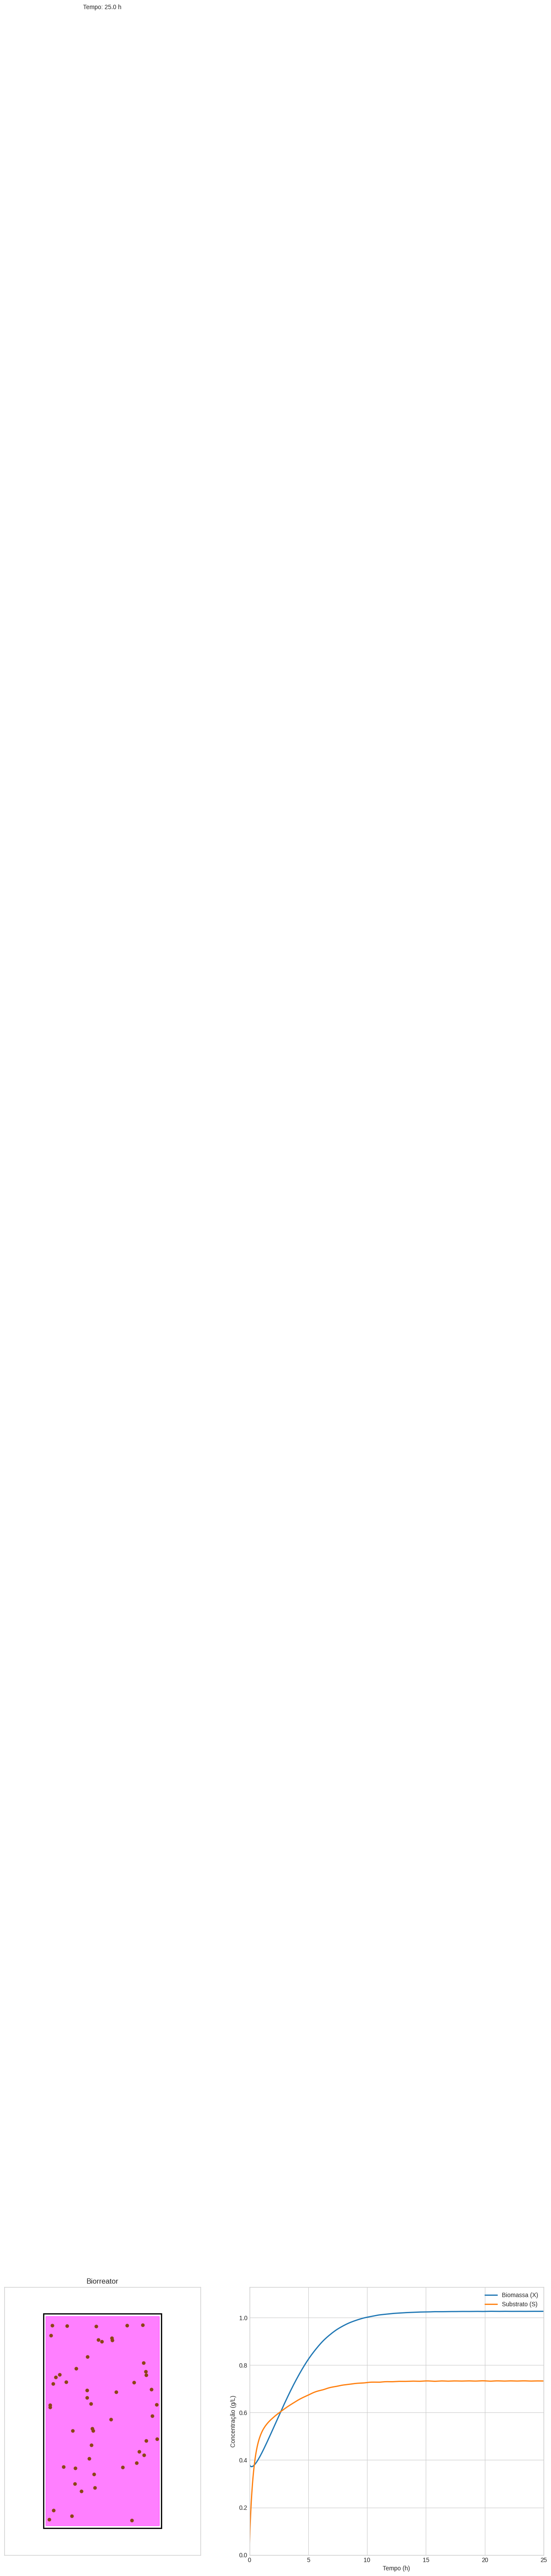

In [51]:
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

# --- PASSO 1: RODE SUA SIMULAÇÃO LQR/LQG E OBTENHA OS DADOS ---
# Suponha que você já tenha rodado e tenha os seguintes arrays:
# t_eval, sol.y[0, :], sol.y[1, :], e os valores de D e Sf calculados no loop

t_anim = sol.t
X_anim = sol.y[0, :]
S_anim = sol.y[1, :]
# (Você precisaria modificar o loop de simulação para salvar os valores de D e Sf a cada passo)
# D_anim = ...
# Sf_anim = ...

# --- PASSO 2: SETUP DA FIGURA DA ANIMAÇÃO ---
fig, (ax_reactor, ax_graphs) = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 1.5]})

# Setup do subplot do reator
ax_reactor.set_xlim(0, 10)
ax_reactor.set_ylim(0, 10)
ax_reactor.set_title('Biorreator')
ax_reactor.set_xticks([])
ax_reactor.set_yticks([])

# Desenha o tanque estático
reactor_patch = patches.Rectangle((2, 1), 6, 8, edgecolor='black', facecolor='none', lw=2)
ax_reactor.add_patch(reactor_patch)

# Elementos dinâmicos iniciais
liquid_patch = patches.Rectangle((2.1, 1.1), 5.8, 7.8, facecolor='cyan', alpha=0.5)
ax_reactor.add_patch(liquid_patch)
# Para as partículas, começamos com um scatter plot vazio
particles, = ax_reactor.plot([], [], 'o', color='saddlebrown', markersize=5)
time_text = ax_reactor.text(0.5, 9.5, '', transform=ax_reactor.transAxes, ha='center')

# Setup do subplot dos gráficos
ax_graphs.set_xlim(t_anim[0], t_anim[-1])
ax_graphs.set_ylim(0, max(np.max(X_anim), np.max(S_anim)) * 1.1)
ax_graphs.set_xlabel('Tempo (h)')
ax_graphs.set_ylabel('Concentração (g/L)')
line_X, = ax_graphs.plot([], [], lw=2, label='Biomassa (X)')
line_S, = ax_graphs.plot([], [], lw=2, label='Substrato (S)')
ax_graphs.legend()
ax_graphs.grid(True)

# Função de inicialização da animação
def init():
    line_X.set_data([], [])
    line_S.set_data([], [])
    particles.set_data([], [])
    time_text.set_text('')
    return line_X, line_S, particles, time_text

# Função de atualização (chamada a cada quadro)
def update(frame):
    # Atualiza gráficos de linha
    line_X.set_data(t_anim[:frame], X_anim[:frame])
    line_S.set_data(t_anim[:frame], S_anim[:frame])
    
    # Atualiza visualização do reator
    # Mapeia a concentração de S para uma cor
    s_normalized = S_anim[frame] / np.max(S_anim)
    liquid_patch.set_color(plt.cm.cool(s_normalized))
    
    # Mapeia a concentração de X para o número de partículas
    num_particles = int(X_anim[frame] * 50) # Fator de escala para visualização
    particle_x = 2.2 + 5.6 * np.random.rand(num_particles)
    particle_y = 1.2 + 7.6 * np.random.rand(num_particles)
    particles.set_data(particle_x, particle_y)
    
    # Atualiza texto
    time_text.set_text(f'Tempo: {t_anim[frame]:.1f} h')
    
    return line_X, line_S, particles, time_text

# Cria a animação
ani = FuncAnimation(fig, update, frames=len(t_anim),
                    init_func=init, blit=True, interval=20)

# Para salvar a animação (requer ffmpeg instalado):
ani.save('biorreator_lqr.mp4', writer='ffmpeg', fps=30)
print('Animação salva!')

plt.show()